# **1. Import Library and Open Access to Google Drive Files**

In [428]:
#import data from google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [429]:
#import required library
import re
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings('ignore')

# **2. Import Dataset Files (Data Source)**

In [430]:
#import Dataset Tammah Robah

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

spreadsheet = gc.open('Dataset Tammah Robah')
sheet_name = 'Master Customer'
worksheet = spreadsheet.worksheet(sheet_name)

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
mcust = pd.DataFrame.from_records(rows[1:],columns=rows[0])
mcust.columns = mcust.columns.str.lower()
mcust.head()

,kodecust,namacust,kota,tanggal
0,507,Sulis,Sidoarjo,2023-10-11
1,507,Sulis,Sidoarjo,2023-10-14
2,01A00120,Aisyah Denpasar,Denpasar,2023-10-05
3,01A00143,Zhafa Frozen Up Aning,Mojokerto,2023-10-06
4,01I00016,Indo Kebab,Sidoarjo,2023-10-02


In [431]:
#import Dataset Tammah Robah

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

spreadsheet = gc.open('Dataset Tammah Robah')
sheet_name = 'Data Source'
worksheet = spreadsheet.worksheet(sheet_name)

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
df = pd.DataFrame.from_records(rows[1:],columns=rows[0])
df.columns = df.columns.str.lower()
df.head()

,tanggal,kodecust,kota,propinsi,channel,salesman,barang,qty,total
0,2023-10-02,89,Surabaya,JAWA TIMUR,GT,GN02,ROTI,20,115520
1,2023-10-25,89,Surabaya,JAWA TIMUR,GT,GN02,ROTI,20,255480
2,2023-11-17,89,Surabaya,JAWA TIMUR,GT,GN02,ROTI,20,427000
3,2023-12-26,89,Surabaya,JAWA TIMUR,GT,GN02,ROTI,20,193200
4,2023-10-12,292,Semarang,JAWA TENGAH,FS,DA08,SOSIS,5,75590


# **3. Exploratory Data Analysis (EDA)**

In [432]:
#inspect dataset shape
print('Dataset ini terdiri dari',df.shape[0], 'baris dan terdiri dari',df.shape[1], 'kolom')

Dataset ini terdiri dari 7335 baris dan terdiri dari 9 kolom


In [433]:
#convert columns data type
df[['qty','total']] = df[['qty','total']].astype(int)
df['tanggal'] = pd.to_datetime(df.tanggal,format='%Y-%m-%d')
df['month'] = pd.to_datetime(df['tanggal']).dt.to_period('M')

In [434]:
#inspect the dataset!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7335 entries, 0 to 7334
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   7335 non-null   datetime64[ns]
 1   kodecust  7335 non-null   object        
 2   kota      7335 non-null   object        
 3   propinsi  7335 non-null   object        
 4   channel   7335 non-null   object        
 5   salesman  7335 non-null   object        
 6   barang    7335 non-null   object        
 7   qty       7335 non-null   int64         
 8   total     7335 non-null   int64         
 9   month     7335 non-null   period[M]     
dtypes: datetime64[ns](1), int64(2), object(6), period[M](1)
memory usage: 573.2+ KB


In [435]:
#describe the numeric column
round(df.describe(include='number').astype(float),2)

,qty,total
count,7335.00,7.335000e+03
mean,65.47,1.148707e+06
std,185.26,3.452860e+06
min,0.00,0.000000e+00
25%,10.00,1.136230e+05
50%,20.00,3.430800e+05
75%,50.00,1.024380e+06
max,5600.00,1.134602e+08


In [436]:
#describe the object column
df.describe(include='object')

,kodecust,kota,propinsi,channel,salesman,barang
count,7335,7335,7335,7335,7335,7335
unique,503,99,18,4,14,10
top,C00114,Surabaya,JAWA TIMUR,FS,GN02,SOSIS
freq,446,1191,3765,4379,1822,4749


In [437]:
#filter qty and total only greater than 0
df = df[df['qty']!=0]
df.head()

,tanggal,kodecust,kota,propinsi,channel,salesman,barang,qty,total,month
0,2023-10-02,89,Surabaya,JAWA TIMUR,GT,GN02,ROTI,20,115520,2023-10
1,2023-10-25,89,Surabaya,JAWA TIMUR,GT,GN02,ROTI,20,255480,2023-10
2,2023-11-17,89,Surabaya,JAWA TIMUR,GT,GN02,ROTI,20,427000,2023-11
3,2023-12-26,89,Surabaya,JAWA TIMUR,GT,GN02,ROTI,20,193200,2023-12
4,2023-10-12,292,Semarang,JAWA TENGAH,FS,DA08,SOSIS,5,75590,2023-10


In [438]:
#inspect column propinsi
df['propinsi'].unique()

array(['JAWA TIMUR', 'JAWA TENGAH', 'SULAWESI SELATAN', 'BALI',
       'JAWA BARAT', 'DKI JAKARTA', 'KALIMANTAN SELATAN', 'MALUKU',
       'DI YOGYAKARTA', 'KALIMANTAN TIMUR', 'NUSA TENGGARA BARAT (NTB)',
       'BANTEN', 'PAPUA', '', 'RIAU', 'KALIMANTAN BARAT',
       'SULAWESI TENGAH', 'PAPUA BARAT'], dtype=object)

In [439]:
#inspect kota column
df['kota'].unique()

array(['Surabaya', 'Semarang', 'Sidoarjo', 'Makassar', 'Denpasar',
       'Mojokerto', 'Bekasi', 'Bandung', 'Jakarta', 'Banjarmasin',
       'Depok', 'ambon', 'Jogja', 'Karawang', 'Juwana', 'Samarinda',
       'Blitar', 'Lamongan', 'Lombok Barat', 'Malang', 'Mataram',
       'Banyuwangi', 'Balikpapan', 'Madiun', 'Pasuruan', 'Bali',
       'Surakarta', 'Situbondo', 'Batang', 'Yogyakarta', 'Probolinggo',
       'Jakarta Timur', 'Ponorogo', 'Tangerang', 'Bogor', 'Badung',
       'Jepara', 'denpasar', 'Nganjuk', 'banyumas', 'Tasikmalaya',
       'Jayapura', 'Cilacap', 'Gresik', 'Kediri', 'Klaten', 'Tuban',
       'Madura', 'Lumajang', 'Tangerang Selatan', 'Purwokerto',
       'Tulungagung', 'SIDOARJO', 'Jember', 'Wonosobo', 'Pekalongan',
       'Demak', 'Ngawi', 'Jombang', 'Magetan', 'Cirebon', 'Trenggalek',
       'bali', 'Kuta', 'Brebes', 'Sumenep', 'Kebumen', 'Kaubun', 'Banjar',
       'Bojonegoro', 'Jakarta Barat', 'Kroya', 'Bantul', 'surabaya',
       'Pontianak', 'Maluku', 'Bondowoso

In [440]:
#inspect branag column
df['barang'].unique()

array(['ROTI', 'SOSIS', 'NUGGET', 'PERLENGKAPAN', 'DRY ICE', 'PACKAGING',
       'HAM', 'TEMPURA', 'PERALATAN', 'MAYONAISE'], dtype=object)

In [441]:
#convert kota and propinsi with title string
df['kota'] = df['kota'].str.title()
df['propinsi'] = df['propinsi'].str.title()
df['barang'] = df['barang'].str.title()

In [442]:
#filter and fill whitespace in propinsi column
df[df['propinsi']=='']

,tanggal,kodecust,kota,propinsi,channel,salesman,barang,qty,total,month
3782,2023-12-29,H00119,Surabaya,,GT,DL06,Sosis,20,225240,2023-12
5280,2023-12-23,N00417,Surabaya,,GT,GN02,Nugget,1,20183,2023-12
5281,2023-12-23,N00417,Surabaya,,GT,GN02,Sosis,10,103600,2023-12


In [443]:
#replace values in propinsi column with proper values
df['propinsi'] = df['propinsi'].replace('',np.nan).fillna('Jawa Timur')
df['propinsi'] = df['propinsi'].replace('Nusa Tenggara Barat (Ntb)','Nusa Tenggara Barat (NTB)')
df['propinsi'] = df['propinsi'].replace('Di Yogyakarta','DI Yogyakarta')
df['propinsi'] = df['propinsi'].replace('Dki Jakarta','DKI Jakarta')
df['propinsi'] = df['propinsi'].replace('Riau','Kalimantan Barat')

df['propinsi'].unique()

array(['Jawa Timur', 'Jawa Tengah', 'Sulawesi Selatan', 'Bali',
       'Jawa Barat', 'DKI Jakarta', 'Kalimantan Selatan', 'Maluku',
       'DI Yogyakarta', 'Kalimantan Timur', 'Nusa Tenggara Barat (NTB)',
       'Banten', 'Papua', 'Kalimantan Barat', 'Sulawesi Tengah',
       'Papua Barat'], dtype=object)

In [444]:
df[['propinsi','kota']].sort_values(by=['propinsi','kota']).drop_duplicates().reset_index(drop=True)

,propinsi,kota
0,Bali,Badung
1,Bali,Bali
2,Bali,Denpasar
3,Bali,Gianyar
4,Bali,Kuta
5,Bali,Singaraja
6,Banten,Serang
7,Banten,Tangerang
8,Banten,Tangerang Selatan
9,DI Yogyakarta,Bantul


In [445]:
#filter and fill whitespace in kota column
df[df['kota']=='']

,tanggal,kodecust,kota,propinsi,channel,salesman,barang,qty,total,month
5309,2023-10-13,N00420,,Kalimantan Barat,GT,DA08,Perlengkapan,1,7093,2023-10
5310,2023-10-13,N00420,,Kalimantan Barat,GT,DA08,Ham,3,17163,2023-10
5311,2023-10-13,N00420,,Kalimantan Barat,GT,DA08,Sosis,10,84590,2023-10


In [446]:
df[df['propinsi']=='Jawa Tengah'][['propinsi','kota']].drop_duplicates()

,propinsi,kota
4,Jawa Tengah,Semarang
732,Jawa Tengah,Juwana
1021,Jawa Tengah,Surakarta
1146,Jawa Tengah,Batang
1167,Jawa Tengah,Yogyakarta
1393,Jawa Tengah,Jepara
1403,Jawa Tengah,Banyumas
1525,Jawa Tengah,Cilacap
1628,Jawa Tengah,Klaten
1771,Jawa Tengah,Purwokerto


In [447]:
#find frequent values of kota column in Kalimantan Barat province to replace '' value in kota column
freq_kalimantan = df[df['propinsi']=='Kalimantan Barat']['kota'].value_counts().idxmax()
freq_kalimantan

'Ketapang'

In [448]:
#find Jakarta in kota column
check_jakarta1 = df[(df['propinsi']=='DKI Jakarta') & (df['kota']!='Jakarta')][['kodecust','channel','propinsi','kota','total','salesman']].drop_duplicates().reset_index(drop=True)
check_jakarta1.head()

,kodecust,channel,propinsi,kota,total,salesman
0,A00878,FS,DKI Jakarta,Jakarta Timur,2024640,WD05
1,A00878,FS,DKI Jakarta,Jakarta Timur,1112280,WD05
2,A00878,FS,DKI Jakarta,Jakarta Timur,1545120,WD05
3,A00878,FS,DKI Jakarta,Jakarta Timur,1125880,WD05
4,A00878,FS,DKI Jakarta,Jakarta Timur,838000,WD05


In [449]:
check_jakarta1.groupby(by=['kota']).agg(revenue=('total','sum')).sort_values('revenue',ascending=False).reset_index()

,kota,revenue
0,Jakarta Barat,151881300
1,Jakarta Timur,70082220
2,Jakarta Utara,15568408
3,Jakarta Pusat,1223068


In [450]:
check_jakarta1.groupby(by=['kodecust','kota']).agg(revenue=('total','sum')).reset_index()

,kodecust,kota,revenue
0,A00878,Jakarta Timur,66181970
1,K00017,Jakarta Barat,151881300
2,N00425,Jakarta Timur,1284440
3,N00428,Jakarta Pusat,1223068
4,P00139,Jakarta Utara,11631928
5,P00233,Jakarta Utara,3936480
6,P00234,Jakarta Timur,1484700
7,S00506,Jakarta Timur,1131110


In [451]:
#find Jakarta in kota column
check_jakarta2 = df[(df['propinsi']=='DKI Jakarta') & (df['kota']=='Jakarta')][['kodecust','channel','propinsi','kota','total','salesman']].drop_duplicates().reset_index(drop=True)
check_jakarta2.head()

,kodecust,channel,propinsi,kota,total,salesman
0,01H00060,GT,DKI Jakarta,Jakarta,1021900,WD05
1,01H00060,GT,DKI Jakarta,Jakarta,733300,WD05
2,01H00060,GT,DKI Jakarta,Jakarta,3167360,WD05
3,01H00060,GT,DKI Jakarta,Jakarta,730400,WD05
4,01H00060,GT,DKI Jakarta,Jakarta,849250,WD05


In [452]:
check_jakarta2.groupby(by=['kodecust','kota']).agg(revenue=('total','sum')).reset_index()

,kodecust,kota,revenue
0,01H00060,Jakarta,205963025
1,01W00017,Jakarta,1304850
2,A00029,Jakarta,4349300
3,A00443,Jakarta,13902640
4,A00877,Jakarta,29505780
5,A00885,Jakarta,5363600
6,B00409,Jakarta,512790
7,D00171,Jakarta,1977270
8,D00380,Jakarta,7438700
9,D00393,Jakarta,729663590


In [453]:
#count values kota that contains Jakarta
df[df['kota'].str.contains('Jakarta')][['kota']].value_counts()

kota         
Jakarta          252
Jakarta Timur     54
Jakarta Barat     30
Jakarta Utara      7
Jakarta Pusat      2
Name: count, dtype: int64

In [454]:
#replace '' value in kota column and other values
df['kota'] = df['kota'].replace('',freq_kalimantan)
df['kota'] = df['kota'].replace('Jogja','Yogyakarta')
df['kota'] = df['kota'].replace('Kaiman','Kaimana')
df['kota'] = df['kota'].replace('Jakarta Timur','Jakarta')
df['kota'] = df['kota'].replace('Jakarta Barat','Jakarta')
df['kota'] = df['kota'].replace('Jakarta Utara','Jakarta')
df['kota'] = df['kota'].replace('Jakarta Pusat','Jakarta')

df['kota'].unique()

array(['Surabaya', 'Semarang', 'Sidoarjo', 'Makassar', 'Denpasar',
       'Mojokerto', 'Bekasi', 'Bandung', 'Jakarta', 'Banjarmasin',
       'Depok', 'Ambon', 'Yogyakarta', 'Karawang', 'Juwana', 'Samarinda',
       'Blitar', 'Lamongan', 'Lombok Barat', 'Malang', 'Mataram',
       'Banyuwangi', 'Balikpapan', 'Madiun', 'Pasuruan', 'Bali',
       'Surakarta', 'Situbondo', 'Batang', 'Probolinggo', 'Ponorogo',
       'Tangerang', 'Bogor', 'Badung', 'Jepara', 'Nganjuk', 'Banyumas',
       'Tasikmalaya', 'Jayapura', 'Cilacap', 'Gresik', 'Kediri', 'Klaten',
       'Tuban', 'Madura', 'Lumajang', 'Tangerang Selatan', 'Purwokerto',
       'Tulungagung', 'Jember', 'Wonosobo', 'Pekalongan', 'Demak',
       'Ngawi', 'Jombang', 'Magetan', 'Cirebon', 'Trenggalek', 'Kuta',
       'Brebes', 'Sumenep', 'Kebumen', 'Kaubun', 'Banjar', 'Bojonegoro',
       'Kroya', 'Bantul', 'Pontianak', 'Maluku', 'Bondowoso', 'Tanjung',
       'Purwakarta', 'Palu', 'Ketapang', 'Serang', 'Purworejo', 'Kudus',
       'Sumbaw

In [455]:
#filter kota Purwakarta but the province in Jawa Tengah
df_pwt = df[(df['kota']=='Purwakarta') & (df['propinsi']=='Jawa Tengah')]
df_pwt['propinsi'] = df_pwt['propinsi'].replace('Jawa Tengah','Jawa Barat')

df_pwt[['propinsi','kota']]

,propinsi,kota
7094,Jawa Barat,Purwakarta


In [456]:
#merge with df
df = df[~((df['kota']=='Purwakarta') & (df['propinsi']=='Jawa Tengah'))]
df = pd.concat([df,df_pwt], ignore_index=True)

df[df['kota']=='Purwakarta'][['propinsi','kota']].drop_duplicates()

,propinsi,kota
4865,Jawa Barat,Purwakarta


In [457]:
#filter kota Kuta but the province in Jawa Timur
df_kuta = df[(df['kota']=='Kuta') & (df['propinsi']=='Jawa Timur')]
df_kuta['propinsi'] = df_kuta['propinsi'].replace('Jawa Timur','Bali')

df_kuta[['propinsi','kota']]

,propinsi,kota
3701,Bali,Kuta


In [458]:
#merge with df
df = df[~((df['kota']=='Kuta') & (df['propinsi']=='Jawa Timur'))]
df = pd.concat([df,df_kuta], ignore_index=True)

df[df['kota']=='Kuta'][['propinsi','kota']].drop_duplicates()

,propinsi,kota
4270,Bali,Kuta


In [459]:
#filter kota Yogyakarta but the province in Jawa Tengah
df_jogja = df[(df['kota']=='Yogyakarta') & (df['propinsi']=='Jawa Tengah')]
df_jogja['propinsi'] = df_jogja['propinsi'].replace('Jawa Tengah','DI Yogyakarta')

df_jogja[['propinsi','kota']].drop_duplicates()

,propinsi,kota
1059,DI Yogyakarta,Yogyakarta


In [460]:
#merge with df
df = df[~((df['kota']=='Yogyakarta') & (df['propinsi']=='Jawa Tengah'))]
df = pd.concat([df,df_jogja], ignore_index=True)

df[df['kota']=='Yogyakarta'][['propinsi','kota']].drop_duplicates()

,propinsi,kota
563,DI Yogyakarta,Yogyakarta


In [461]:
# merge with master customer
df = df.merge(mcust[['kodecust','namacust','kota']].drop_duplicates(),how='left',on=['kodecust','kota'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6838 entries, 0 to 6837
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tanggal   6838 non-null   datetime64[ns]
 1   kodecust  6838 non-null   object        
 2   kota      6838 non-null   object        
 3   propinsi  6838 non-null   object        
 4   channel   6838 non-null   object        
 5   salesman  6838 non-null   object        
 6   barang    6838 non-null   object        
 7   qty       6838 non-null   int64         
 8   total     6838 non-null   int64         
 9   month     6838 non-null   period[M]     
 10  namacust  2708 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7), period[M](1)
memory usage: 587.8+ KB


In [462]:
#fill null value in namacust with kodecust and channel
df['namacust'] = df['namacust'].fillna(df['kodecust']+'_'+df['channel'])
df['transaction_id'] = df['tanggal'].astype(str)+ df['kodecust'] + df['channel'] + df['salesman']
df['transaction_id'] = df['transaction_id'].str.replace('-','')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6838 entries, 0 to 6837
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tanggal         6838 non-null   datetime64[ns]
 1   kodecust        6838 non-null   object        
 2   kota            6838 non-null   object        
 3   propinsi        6838 non-null   object        
 4   channel         6838 non-null   object        
 5   salesman        6838 non-null   object        
 6   barang          6838 non-null   object        
 7   qty             6838 non-null   int64         
 8   total           6838 non-null   int64         
 9   month           6838 non-null   period[M]     
 10  namacust        6838 non-null   object        
 11  transaction_id  6838 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8), period[M](1)
memory usage: 641.2+ KB


In [463]:
df.head()

,tanggal,kodecust,kota,propinsi,channel,salesman,barang,qty,total,month,namacust,transaction_id
0,2023-10-02,89,Surabaya,Jawa Timur,GT,GN02,Roti,20,115520,2023-10,89_GT,2023100289GTGN02
1,2023-10-25,89,Surabaya,Jawa Timur,GT,GN02,Roti,20,255480,2023-10,89_GT,2023102589GTGN02
2,2023-11-17,89,Surabaya,Jawa Timur,GT,GN02,Roti,20,427000,2023-11,89_GT,2023111789GTGN02
3,2023-12-26,89,Surabaya,Jawa Timur,GT,GN02,Roti,20,193200,2023-12,89_GT,2023122689GTGN02
4,2023-10-12,292,Semarang,Jawa Tengah,FS,DA08,Sosis,5,75590,2023-10,292_FS,20231012292FSDA08


In [464]:
#create customer new and existing
df_cust_occurence = df.sort_values(by=['tanggal','kodecust'],ascending=True).reset_index(drop=True)
df_cust_occurence = df_cust_occurence.assign(cust_occurence=np.where(~df_cust_occurence['kodecust'].duplicated(),'New Customer','Existing Customer'))
df_cust_occurence.head()

,tanggal,kodecust,kota,propinsi,channel,salesman,barang,qty,total,month,namacust,transaction_id,cust_occurence
0,2023-10-02,01C00017,Bandung,Jawa Barat,GT,DL06,Sosis,6,86802,2023-10,01C00017_GT,2023100201C00017GTDL06,New Customer
1,2023-10-02,01C00017,Bandung,Jawa Barat,GT,DL06,Sosis,7,138299,2023-10,01C00017_GT,2023100201C00017GTDL06,Existing Customer
2,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,50,1021900,2023-10,01H00060_GT,2023100201H00060GTWD05,New Customer
3,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,50,733300,2023-10,01H00060_GT,2023100201H00060GTWD05,Existing Customer
4,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,140,3167360,2023-10,01H00060_GT,2023100201H00060GTWD05,Existing Customer


In [465]:
# create customer new and existing
df_cust_occurence_group_daily = df_cust_occurence.groupby(by=['tanggal','cust_occurence']).agg(cust_cnt=('kodecust','nunique'),
                                                                     purchase_freq=('transaction_id','nunique'),
                                                                     quantity=('qty','sum'),
                                                                     revenue=('total','sum')).sort_values(by=['tanggal','cust_occurence'], ascending=[True,False]).reset_index()
df_cust_occurence_group_daily.head()

,tanggal,cust_occurence,cust_cnt,purchase_freq,quantity,revenue
0,2023-10-02,New Customer,25,25,787,10986944
1,2023-10-02,Existing Customer,18,18,4832,81093853
2,2023-10-03,New Customer,37,37,686,11269409
3,2023-10-03,Existing Customer,30,30,4384,76593048
4,2023-10-04,New Customer,25,25,701,12491321


In [466]:
# create customer new and existing
df_cust_occurence_group = df_cust_occurence.groupby(by=['month','cust_occurence']).agg(cust_cnt=('kodecust','nunique'),
                                                                     purchase_freq=('transaction_id','nunique'),
                                                                     quantity=('qty','sum'),
                                                                     revenue=('total','sum')).sort_values(by=['month','cust_occurence'], ascending=[True,False]).reset_index()
df_cust_occurence_group

,month,cust_occurence,cust_cnt,purchase_freq,quantity,revenue
0,2023-10,New Customer,364,364,9260,164914721
1,2023-10,Existing Customer,312,686,138726,2467670770
2,2023-11,New Customer,86,86,1480,24013817
3,2023-11,Existing Customer,329,718,151804,2668332962
4,2023-12,New Customer,52,52,961,18629881
5,2023-12,Existing Customer,334,737,178024,3082202908


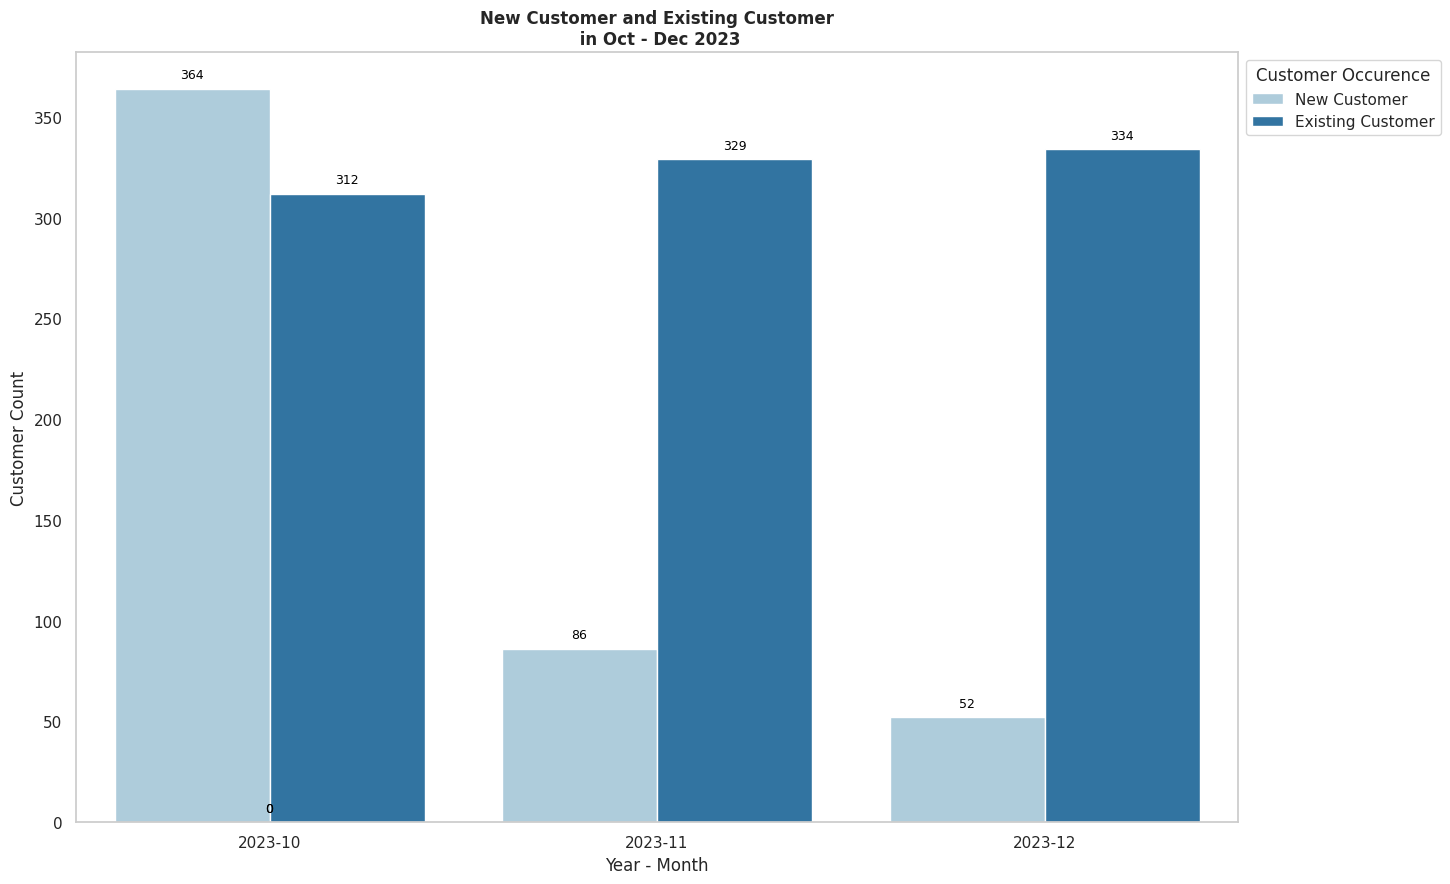

In [467]:
 #create grouped_new_cust to create bar chart
grouped_new_cust = df_cust_occurence_group[['month','cust_occurence','cust_cnt']]

# Create a Bar Chart to show New Customer and New Customer Existing Monthly
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
plt.grid(False)

fig = sns.barplot(x='month',
                  y='cust_cnt', hue='cust_occurence',
                  data = grouped_new_cust.sort_values(by=['month','cust_occurence'], ascending=[True,False]),
                  palette='Paired')

plt.legend(title='Customer Occurence', loc='upper left',bbox_to_anchor=(1.0, 1.0))

# Add labels to the bars
ax = fig.axes
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

# Adding labels and a title
plt.xlabel('Year - Month')
plt.ylabel('Customer Count')
plt.title('New Customer and Existing Customer\n in Oct - Dec 2023', fontweight='bold', fontsize = 12)

# Show the chart
plt.show()

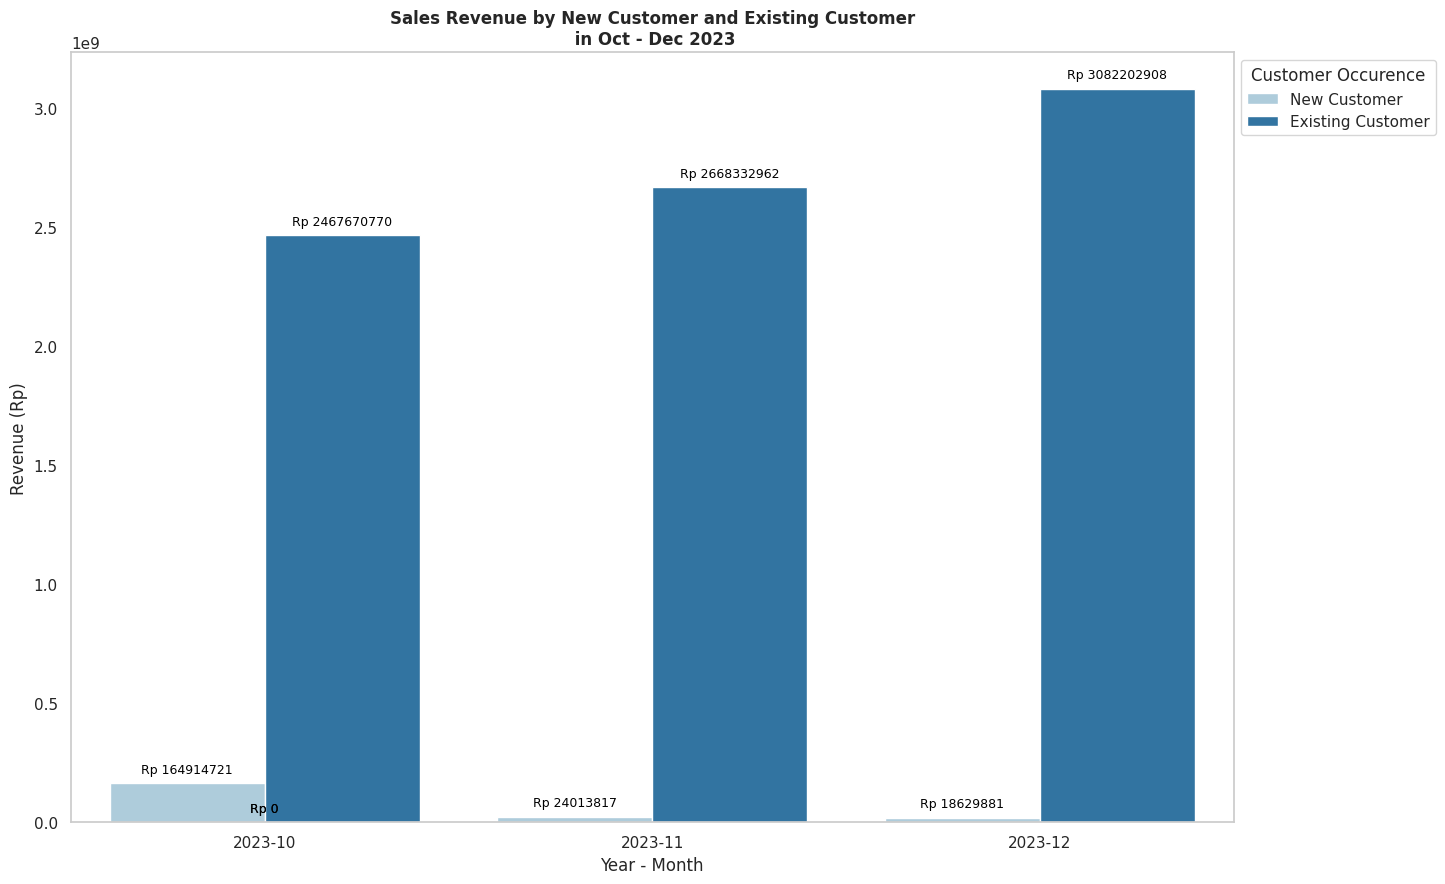

In [468]:
 #create grouped_new_cust to create bar chart
grouped_new_cust = df_cust_occurence_group[['month','cust_occurence','revenue']]

# Create a Bar Chart to show New Customer and New Customer Existing Monthly
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
plt.grid(False)

fig = sns.barplot(x='month',
                  y='revenue', hue='cust_occurence',
                  data = grouped_new_cust.sort_values(by=['month','cust_occurence'], ascending=[True,False]),
                  palette='Paired')

plt.legend(title='Customer Occurence', loc='upper left',bbox_to_anchor=(1.0, 1.0))

# Add labels to the bars
ax = fig.axes
for p in ax.patches:
    ax.annotate(f'Rp {int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

# Adding labels and a title
plt.xlabel('Year - Month')
plt.ylabel('Revenue (Rp)')
plt.title('Sales Revenue by New Customer and Existing Customer\n in Oct - Dec 2023', fontweight='bold', fontsize = 12)

# Show the chart
plt.show()

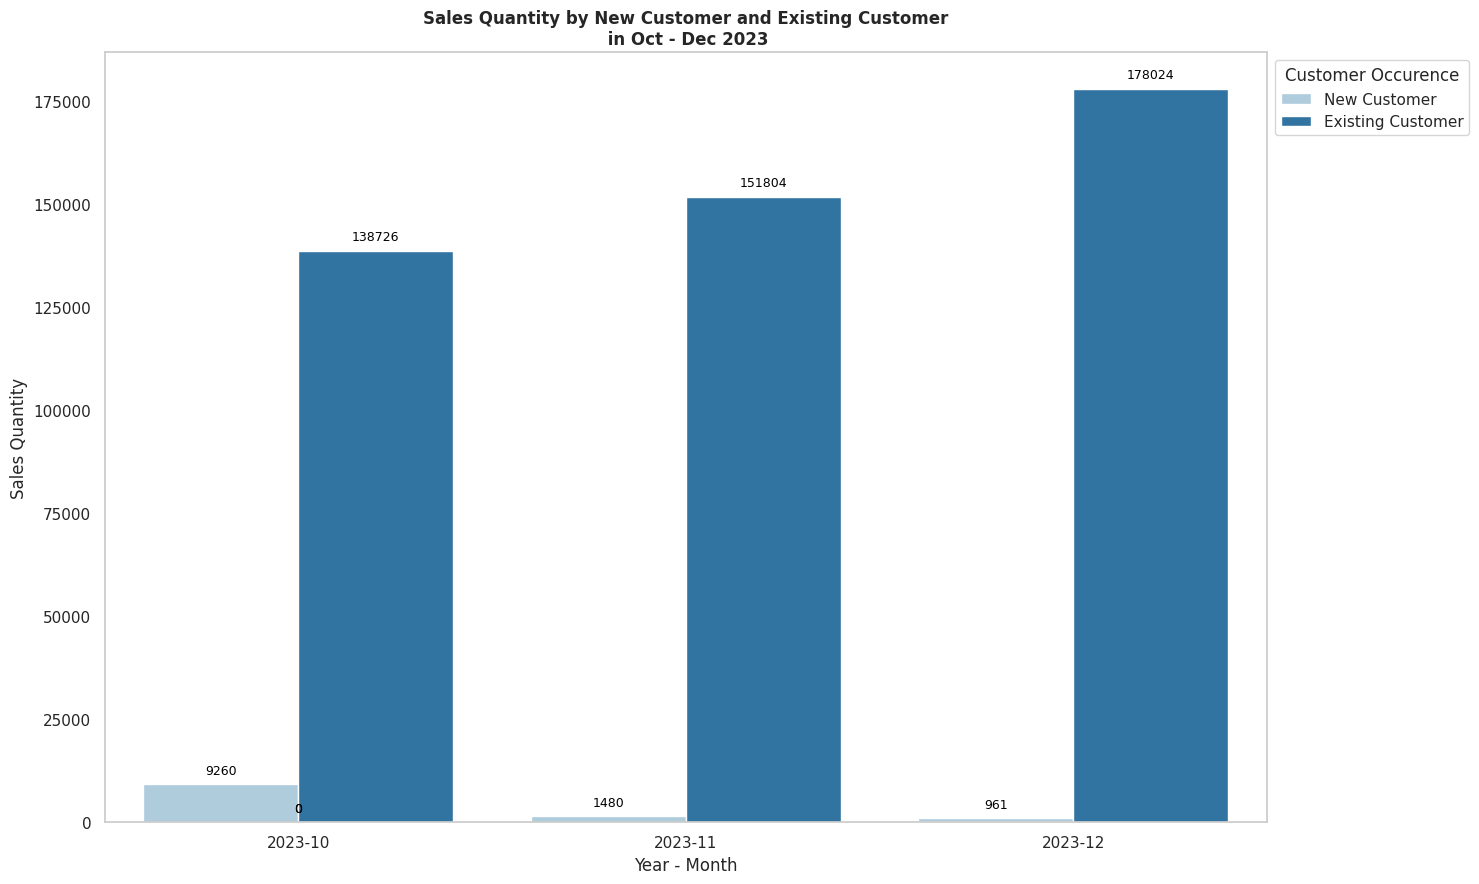

In [469]:
 #create grouped_new_cust to create bar chart
grouped_new_cust = df_cust_occurence_group[['month','cust_occurence','quantity']]

# Create a Bar Chart to show New Customer and New Customer Existing Monthly
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
plt.grid(False)
fig = sns.barplot(x='month',
                  y='quantity', hue='cust_occurence',
                  data = grouped_new_cust.sort_values(by=['month','cust_occurence'], ascending=[True,False]),
                  palette='Paired')

plt.legend(title='Customer Occurence', loc='upper left',bbox_to_anchor=(1.0, 1.0))

# Add labels to the bars
ax = fig.axes
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

# Adding labels and a title
plt.xlabel('Year - Month')
plt.ylabel('Sales Quantity')
plt.title('Sales Quantity by New Customer and Existing Customer\n in Oct - Dec 2023', fontweight='bold', fontsize = 12)

# Show the chart
plt.show()

In [470]:
#group revenue by channel
df_channel = df.groupby(by=['channel']).agg(cust_number=('kodecust','nunique'),
                                            revenue=('total','sum'),
                                            quantity=('qty','sum')).sort_values(by=['channel','revenue'], ascending=False).reset_index()
df_channel.style.background_gradient(cmap='BuGn')

,channel,cust_number,revenue,quantity
0,MT,14,18824549,1005
1,GT,202,2255183557,129122
2,FS,253,5847920039,332773
3,EU,33,303836914,17355


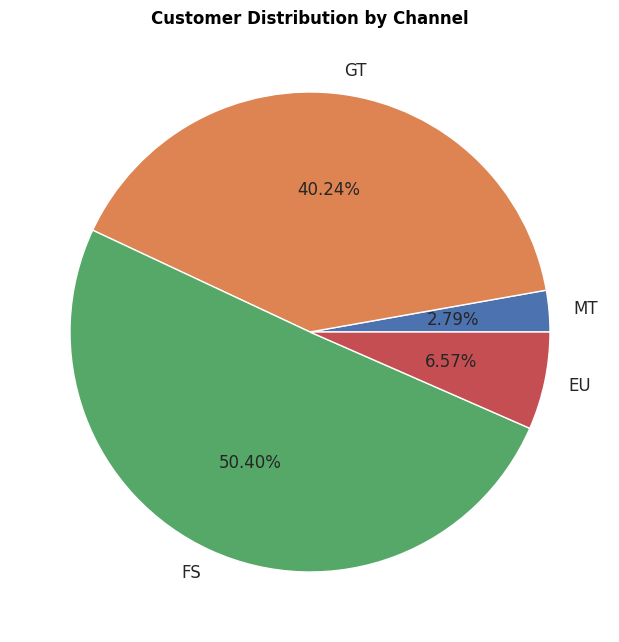

In [471]:
#create pie chart from df_channel
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(df_channel['cust_number'], labels=df_channel['channel'], autopct= '%.2f%%',textprops={'fontsize': 12})
plt.title(label = 'Customer Distribution by Channel',
          size = 12,
          fontweight = 'bold',
          color = 'black')
plt.show()

In [472]:
#group revenue by province and kota
df_city = df.groupby(by=['propinsi','kota']).agg(revenue=('total','sum'),
                                                     quantity=('qty','sum')).sort_values(by=['propinsi','revenue'], ascending=[True,False]).reset_index()
df_city.reset_index(drop=True).style.background_gradient(cmap='BuGn')

,propinsi,kota,revenue,quantity
0,Bali,Denpasar,743827596,41842
1,Bali,Bali,193592910,11646
2,Bali,Gianyar,13936720,830
3,Bali,Badung,6502950,325
4,Bali,Singaraja,5598317,507
5,Bali,Kuta,4820115,255
6,Banten,Tangerang,160371618,9931
7,Banten,Tangerang Selatan,8059749,424
8,Banten,Serang,1067498,50
9,DI Yogyakarta,Yogyakarta,551062767,30588


In [473]:
df.groupby(by=['propinsi']).agg(revenue=('total','sum'),
                                quantity=('qty','sum')).sort_values(by=['revenue'], ascending=False).reset_index().style.background_gradient(cmap='BuGn')

,propinsi,revenue,quantity
0,Jawa Timur,2543145855,144752
1,DKI Jakarta,1398052617,77295
2,Jawa Barat,1104539356,63271
3,Bali,968278608,55405
4,Jawa Tengah,769052680,44399
5,DI Yogyakarta,563047758,31348
6,Kalimantan Timur,381065271,22643
7,Sulawesi Selatan,354681441,19944
8,Banten,169498865,10405
9,Nusa Tenggara Barat (NTB),100142959,6208


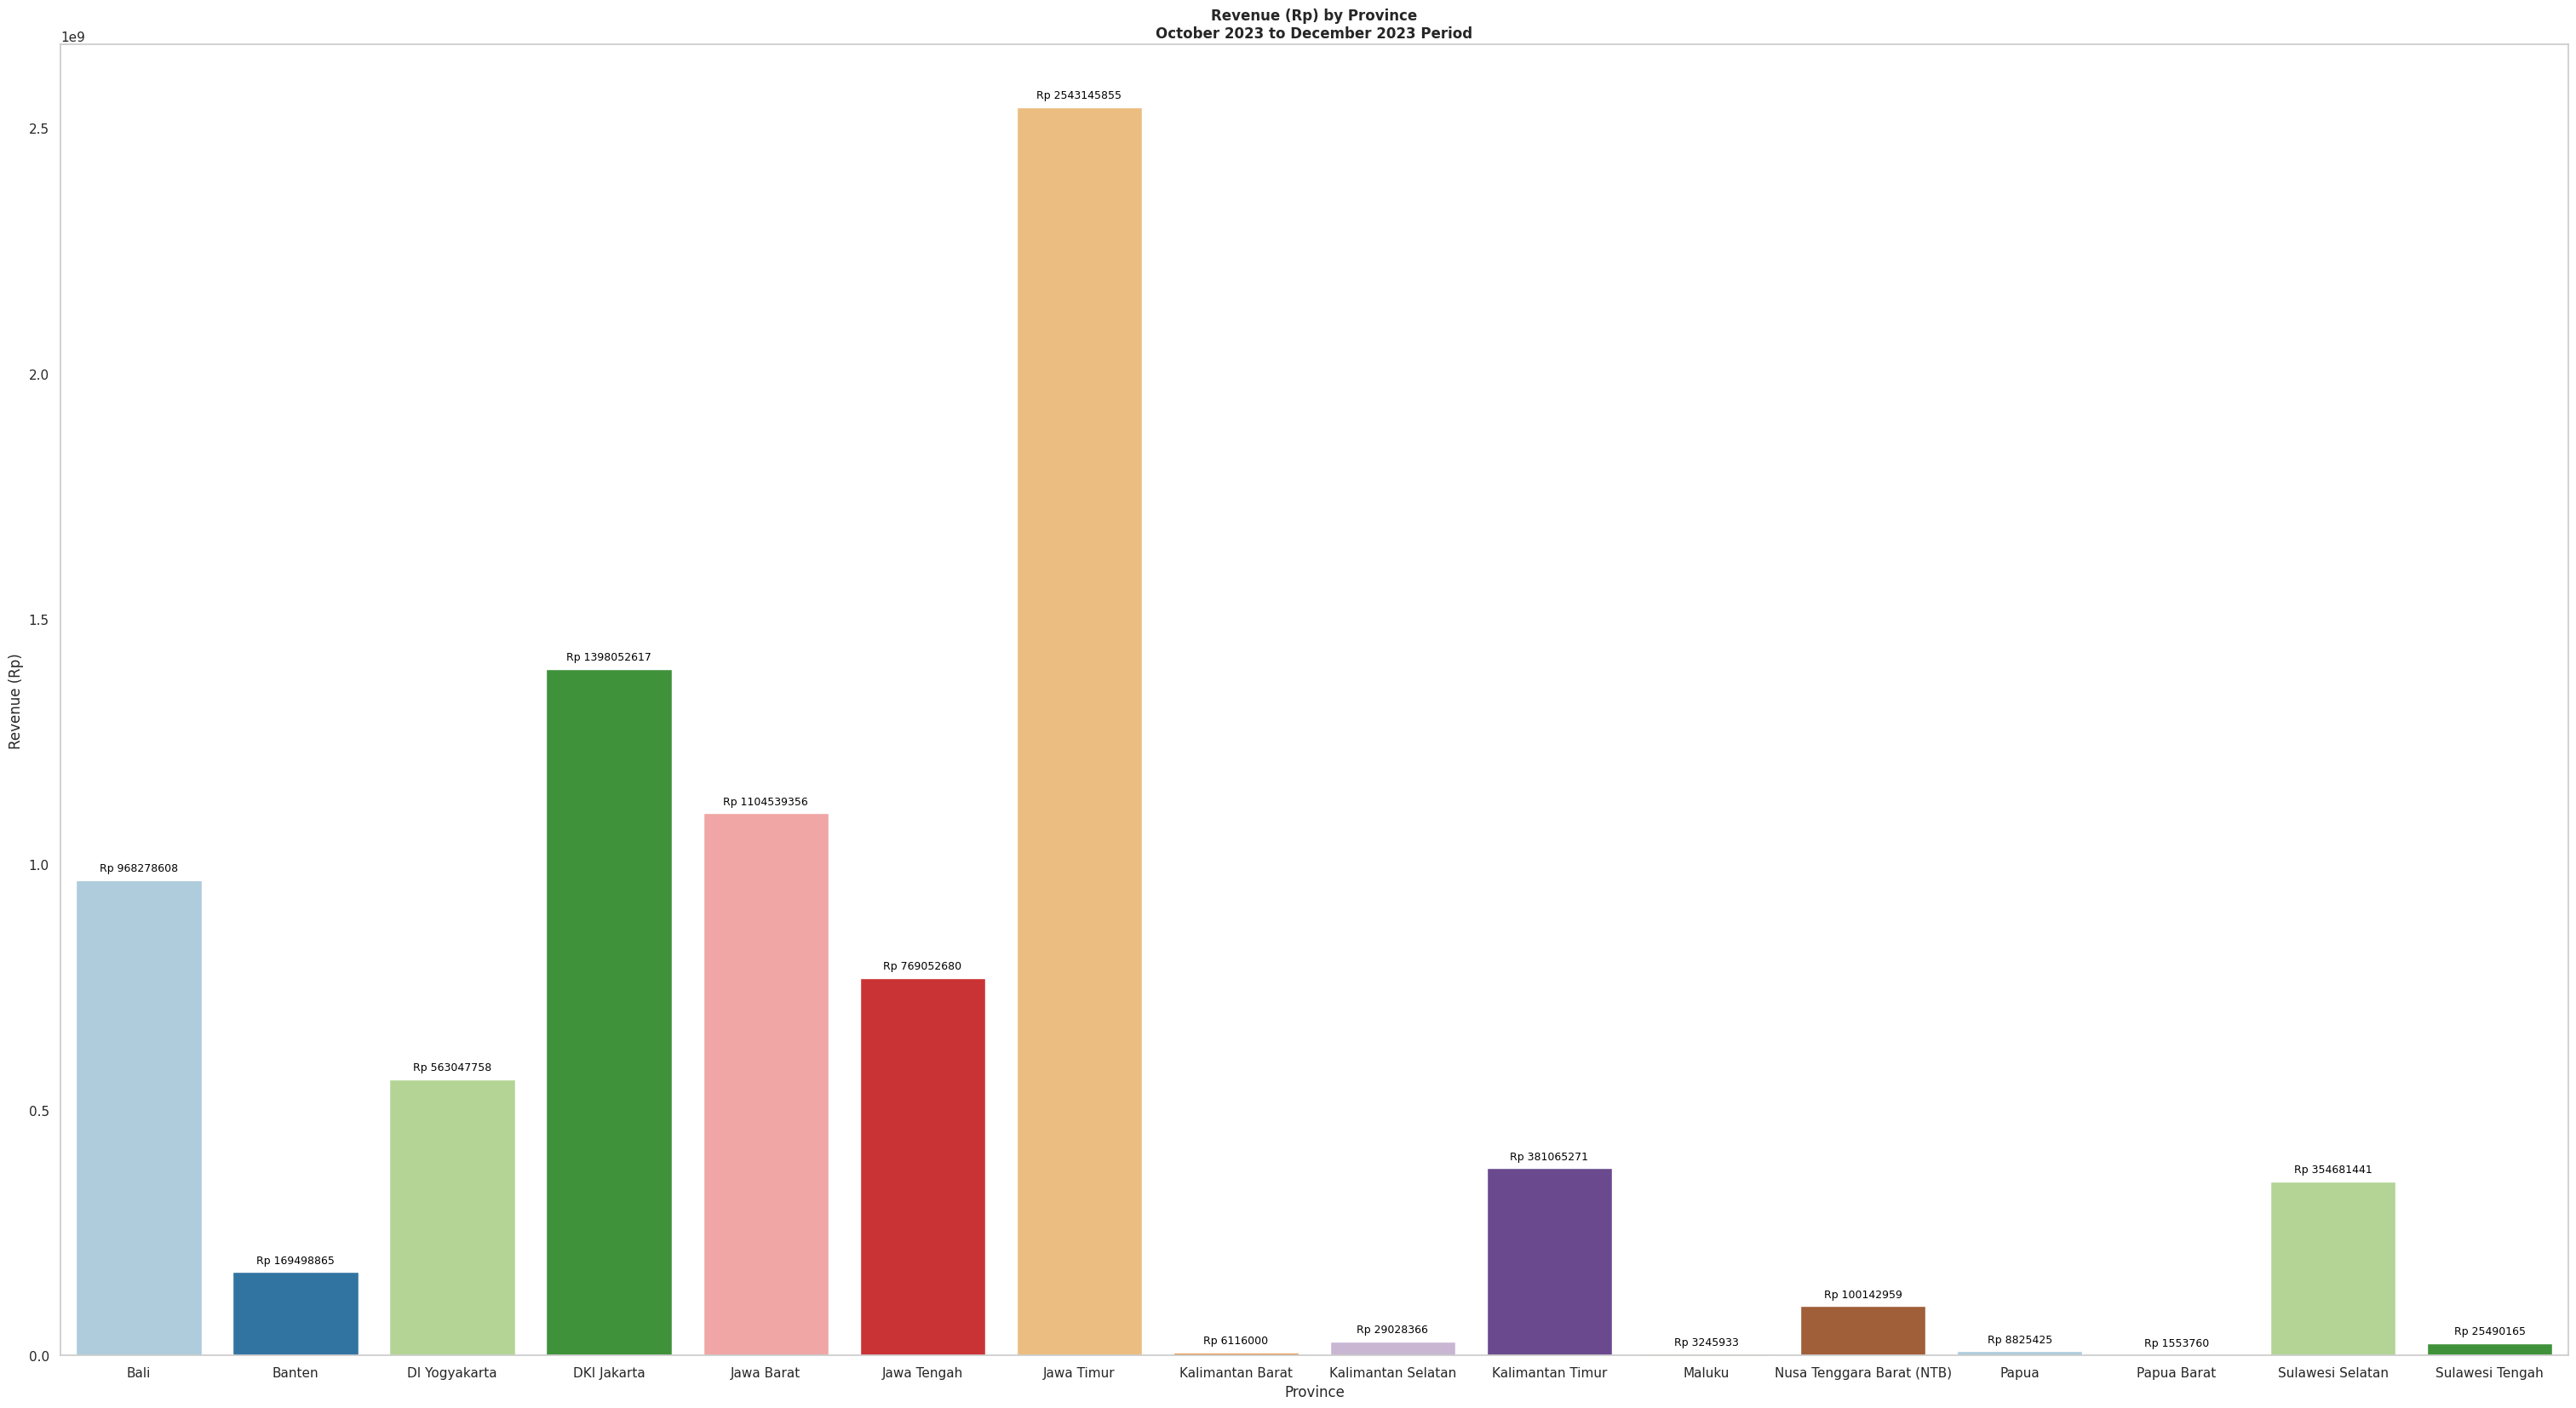

In [474]:
#create bar chart for revenue by province
df_province = df.groupby(by=['propinsi']).agg(revenue=('total','sum'),
                                              quantity=('qty','sum')).reset_index()

plt.figure(figsize=(38, 20))  # Adjust the figure size if needed
fig = sns.barplot(x='propinsi', y='revenue', data=df_province, palette='Paired',ci=None)
plt.grid(False)
# Add labels to the bars
ax = fig.axes
for p in ax.patches:
    ax.annotate(f'Rp {round(int(p.get_height()),1)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')


# Adding labels and a title
plt.xlabel('Province')
plt.ylabel('Revenue (Rp)')
plt.title('Revenue (Rp) by Province\nOctober 2023 to December 2023 Period', fontweight='bold', fontsize = 12)

# Show the chart
plt.show()

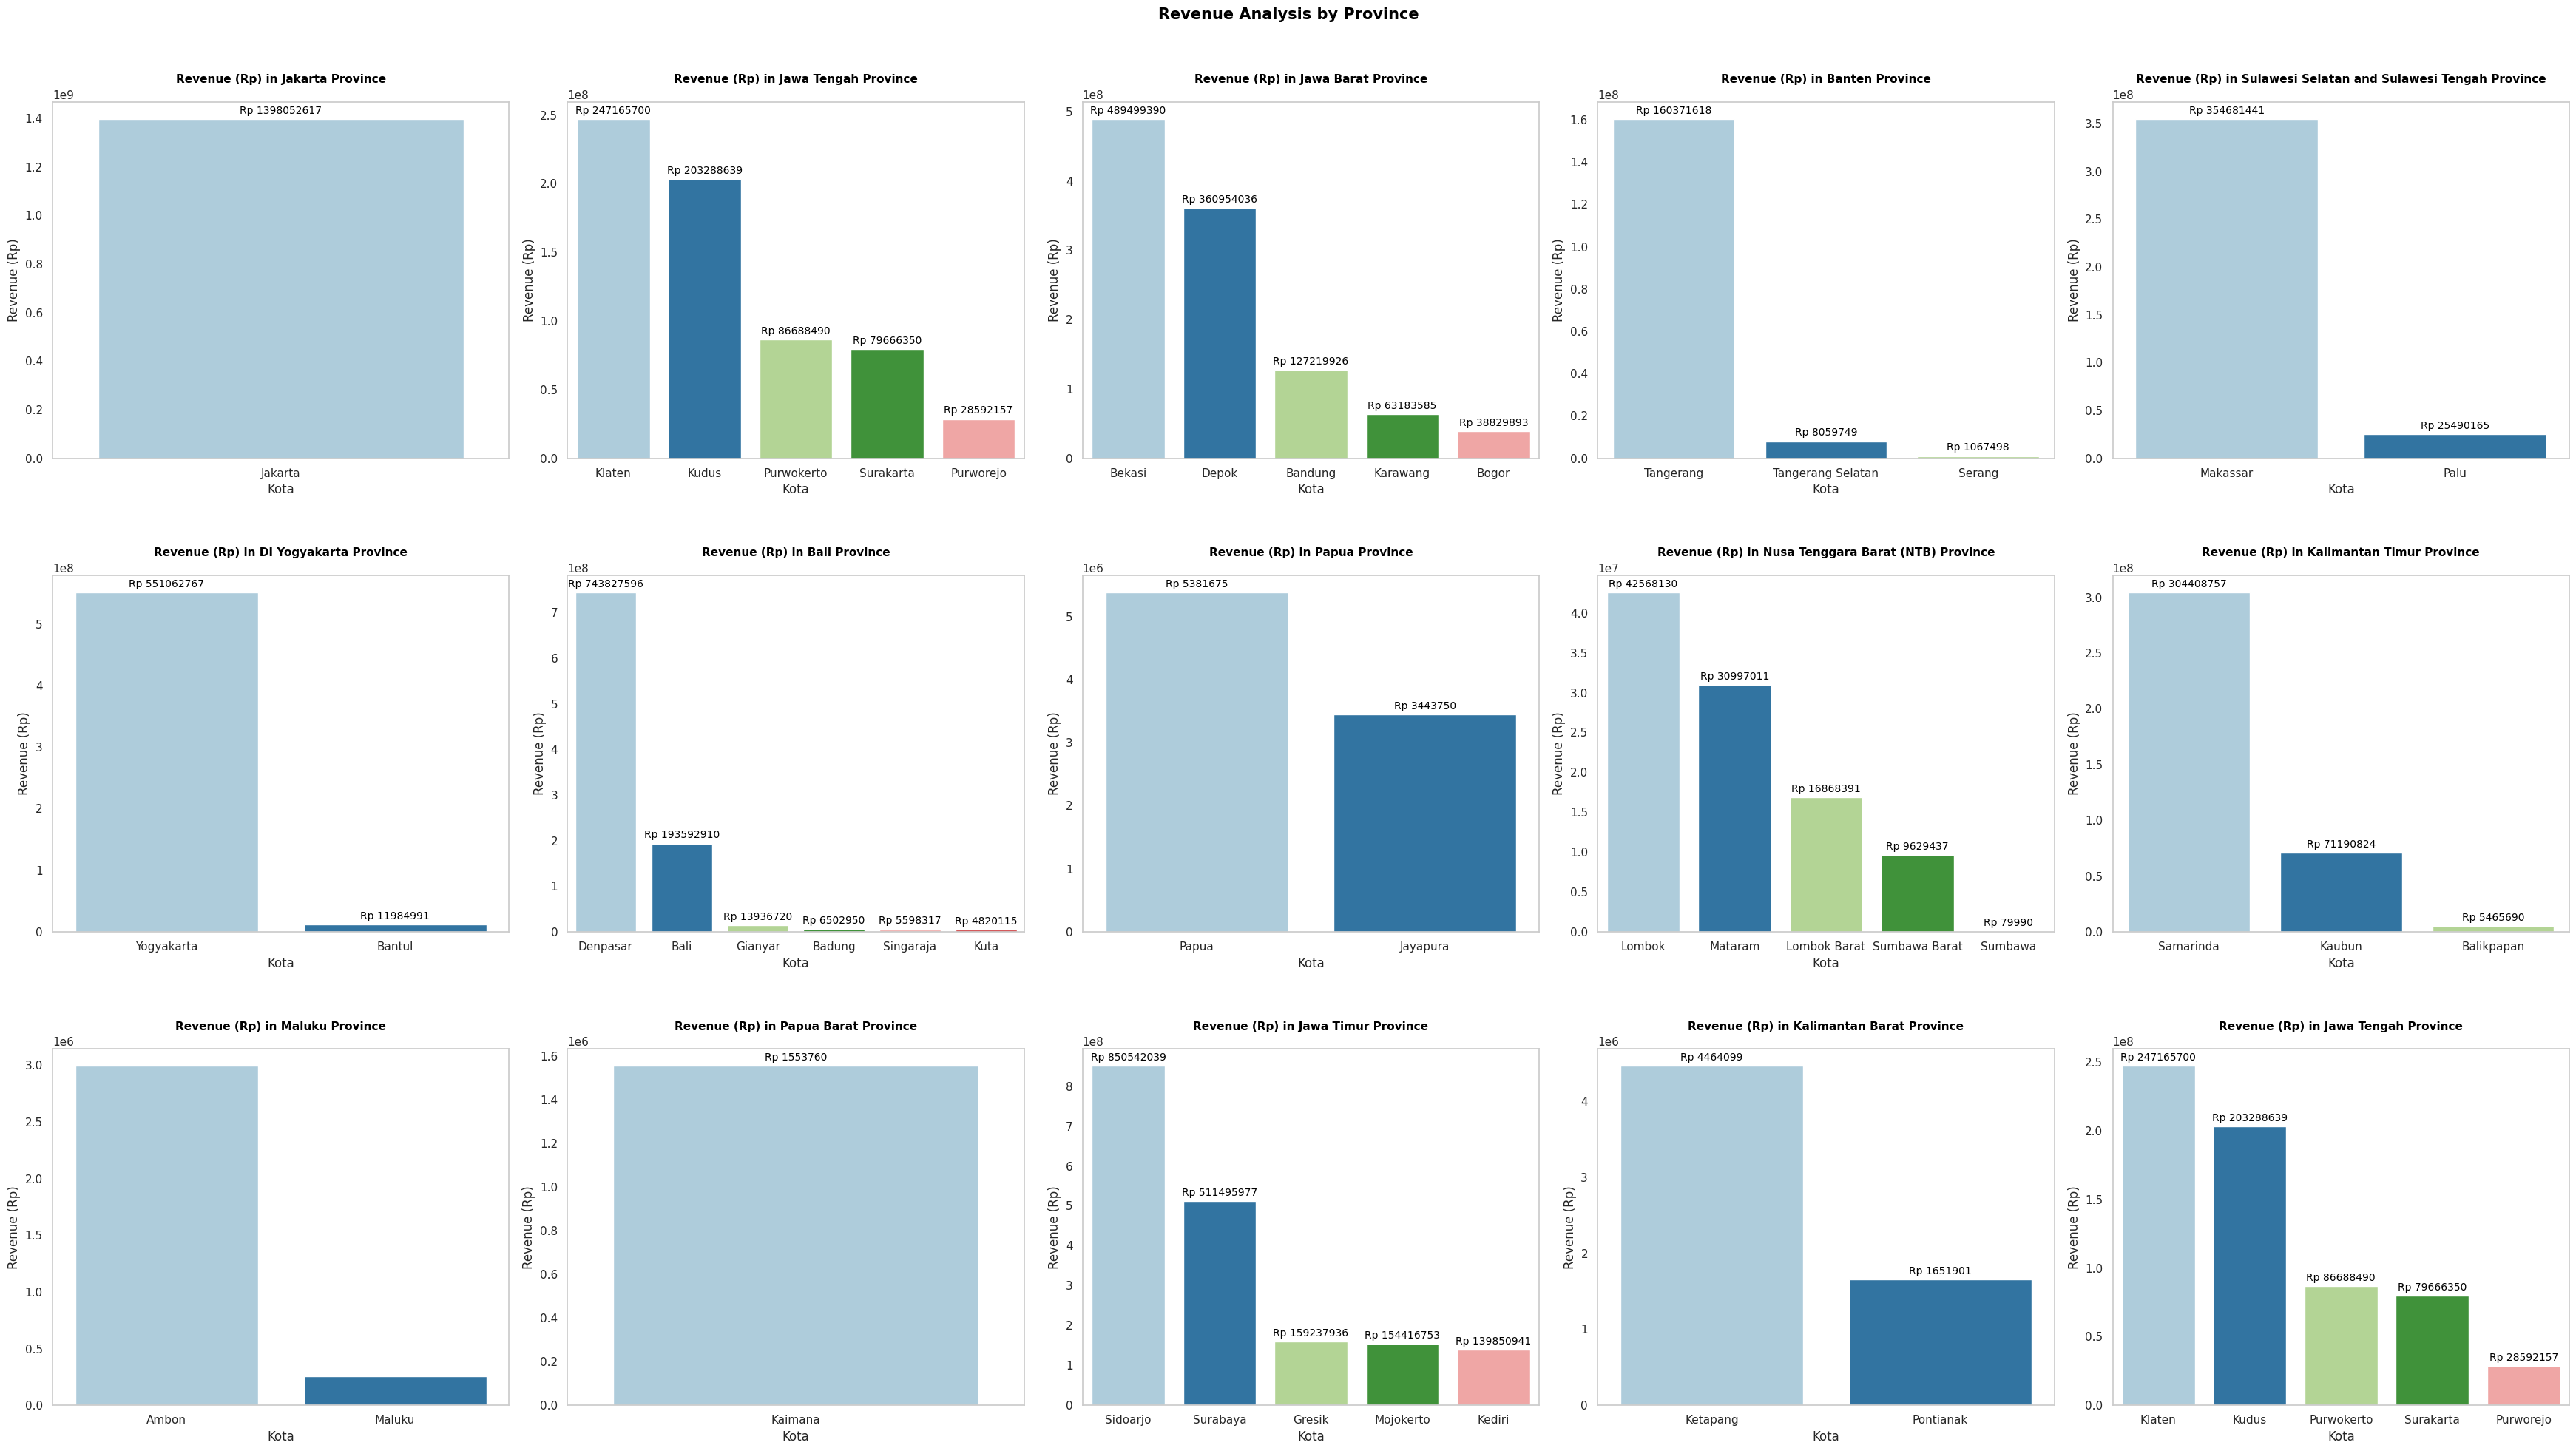

In [475]:
# Create subplots with 3 rows and 5 columns
fig, axes = plt.subplots(3, 5, figsize=(35, 20))

#Give Title
fig.suptitle('Revenue Analysis by Province\n',color = 'black', fontweight= 'bold',fontsize = 15)


# Plot a bar chart for Jakarta
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='DKI Jakarta'], palette='Paired', ax=axes[0, 0])
axes[0][0].set_title('\n\nRevenue (Rp) in Jakarta Province\n', fontweight='bold', fontsize=11, color='black')
axes[0][0].grid(False)
# Add data labels to the Jakarta bar chart
for bar in axes[0, 0].patches:
    height = bar.get_height()
    axes[0, 0].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[0, 0].set_xlabel('Kota', fontsize=12)
axes[0, 0].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Jateng
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Jawa Tengah'].sort_values('revenue',ascending=False).head(), palette='Paired', ax=axes[0, 1])
axes[0][1].set_title('\n\nRevenue (Rp) in Jawa Tengah Province\n', fontweight='bold', fontsize=11, color='black')
axes[0][1].grid(False)
# Add data labels to the Jateng bar chart
for bar in axes[0, 1].patches:
    height = bar.get_height()
    axes[0, 1].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[0, 1].set_xlabel('Kota', fontsize=12)
axes[0, 1].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Jabar
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Jawa Barat'].sort_values('revenue',ascending=False).head(), palette='Paired', ax=axes[0, 2])
axes[0][2].set_title('\n\nRevenue (Rp) in Jawa Barat Province\n', fontweight='bold', fontsize=11, color='black')
axes[0][2].grid(False)
# Add data labels to the Jabar bar chart
for bar in axes[0, 2].patches:
    height = bar.get_height()
    axes[0, 2].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[0, 2].set_xlabel('Kota', fontsize=12)
axes[0, 2].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Banten
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Banten'].sort_values('revenue',ascending=False), palette='Paired', ax=axes[0, 3])
axes[0][3].set_title('\n\nRevenue (Rp) in Banten Province\n', fontweight='bold', fontsize=11, color='black')
axes[0][3].grid(False)
# Add data labels to the Banten bar chart
for bar in axes[0, 3].patches:
    height = bar.get_height()
    axes[0, 3].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[0, 3].set_xlabel('Kota', fontsize=12)
axes[0, 3].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Sulteng and Sulsel
sns.barplot(x='kota', y='revenue', data=df_city[(df_city['propinsi']=='Sulawesi Tengah') | (df_city['propinsi']=='Sulawesi Selatan')], palette='Paired', ax=axes[0, 4])
axes[0][4].set_title('\n\nRevenue (Rp) in Sulawesi Selatan and Sulawesi Tengah Province\n', fontweight='bold', fontsize=11, color='black')
axes[0][4].grid(False)
# Add data labels to the Sulteng and Sulsel bar chart
for bar in axes[0, 4].patches:
    height = bar.get_height()
    axes[0, 4].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[0, 4].set_xlabel('Kota', fontsize=12)
axes[0, 4].set_ylabel('Revenue (Rp)', fontsize=12)


# Plot a bar chart for Yogyakarta
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='DI Yogyakarta'], palette='Paired', ax=axes[1, 0])
axes[1][0].set_title('\n\nRevenue (Rp) in DI Yogyakarta Province\n', fontweight='bold', fontsize=11, color='black')
axes[1][0].grid(False)
# Add data labels to the Yogyakarta bar chart
for bar in axes[1, 0].patches:
    height = bar.get_height()
    axes[1, 0].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[1, 0].set_xlabel('Kota', fontsize=12)
axes[1, 0].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Bali
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Bali'], palette='Paired', ax=axes[1, 1])
axes[1][1].set_title('\n\nRevenue (Rp) in Bali Province\n', fontweight='bold', fontsize=11, color='black')
axes[1][1].grid(False)
# Add data labels to the Bali bar chart
for bar in axes[1, 1].patches:
    height = bar.get_height()
    axes[1, 1].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[1, 1].set_xlabel('Kota', fontsize=12)
axes[1, 1].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Papua
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Papua'], palette='Paired', ax=axes[1, 2])
axes[1][2].set_title('\n\nRevenue (Rp) in Papua Province\n', fontweight='bold', fontsize=11, color='black')
axes[1][2].grid(False)
# Add data labels to the Papua bar chart
for bar in axes[1, 2].patches:
    height = bar.get_height()
    axes[1, 2].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[1, 2].set_xlabel('Kota', fontsize=12)
axes[1, 2].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for NTB
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Nusa Tenggara Barat (NTB)'], palette='Paired', ax=axes[1, 3])
axes[1][3].set_title('\n\nRevenue (Rp) in Nusa Tenggara Barat (NTB) Province\n', fontweight='bold', fontsize=11, color='black')
axes[1][3].grid(False)
# Add data labels to the NTB bar chart
for bar in axes[1, 3].patches:
    height = bar.get_height()
    axes[1, 3].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[1, 3].set_xlabel('Kota', fontsize=12)
axes[1, 3].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Kaltim
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Kalimantan Timur'], palette='Paired', ax=axes[1, 4])
axes[1][4].set_title('\n\nRevenue (Rp) in Kalimantan Timur Province\n', fontweight='bold', fontsize=11, color='black')
axes[1][4].grid(False)
# Add data labels to the Kaltim bar chart
for bar in axes[1, 4].patches:
    height = bar.get_height()
    axes[1, 4].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[1, 4].set_xlabel('Kota', fontsize=12)
axes[1, 4].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Maluku
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Maluku'], palette='Paired', ax=axes[2, 0])
axes[2][0].set_title('\n\nRevenue (Rp) in Maluku Province\n', fontweight='bold', fontsize=11, color='black')
axes[2][0].grid(False)
# Add data labels to the Maluku bar chart
for bar in axes[1, 0].patches:
    height = bar.get_height()
    axes[2, 0].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[2, 0].set_xlabel('Kota', fontsize=12)
axes[2, 0].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Papua Barat
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Papua Barat'], palette='Paired', ax=axes[2, 1])
axes[2][1].set_title('\n\nRevenue (Rp) in Papua Barat Province\n', fontweight='bold', fontsize=11, color='black')
axes[2][1].grid(False)
# Add data labels to the Papua Barat bar chart
for bar in axes[2, 1].patches:
    height = bar.get_height()
    axes[2, 1].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[2, 1].set_xlabel('Kota', fontsize=12)
axes[2, 1].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Jawa Timur
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Jawa Timur'].sort_values('revenue',ascending=False).head(), palette='Paired', ax=axes[2, 2])
axes[2][2].set_title('\n\nRevenue (Rp) in Jawa Timur Province\n', fontweight='bold', fontsize=11, color='black')
axes[2][2].grid(False)
# Add data labels to the Jawa Timur bar chart
for bar in axes[2, 2].patches:
    height = bar.get_height()
    axes[2, 2].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[2, 2].set_xlabel('Kota', fontsize=12)
axes[2, 2].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Kalbar
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Kalimantan Barat'], palette='Paired', ax=axes[2, 3])
axes[2][3].set_title('\n\nRevenue (Rp) in Kalimantan Barat Province\n', fontweight='bold', fontsize=11, color='black')
axes[2][3].grid(False)
# Add data labels to the Kalbar bar chart
for bar in axes[2, 3].patches:
    height = bar.get_height()
    axes[2, 3].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[2, 3].set_xlabel('Kota', fontsize=12)
axes[2, 3].set_ylabel('Revenue (Rp)', fontsize=12)

# Plot a bar chart for Jateng
sns.barplot(x='kota', y='revenue', data=df_city[df_city['propinsi']=='Jawa Tengah'].sort_values('revenue',ascending=False).head(), palette='Paired', ax=axes[2, 4])
axes[2][4].set_title('\n\nRevenue (Rp) in Jawa Tengah Province\n', fontweight='bold', fontsize=11, color='black')
axes[2][4].grid(False)
# Add data labels to the Jateng bar chart
for bar in axes[2, 4].patches:
    height = bar.get_height()
    axes[2, 4].annotate(f'Rp {height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')
# Set labels for x-axis and y-axis
axes[2, 4].set_xlabel('Kota', fontsize=12)
axes[2, 4].set_ylabel('Revenue (Rp)', fontsize=12)

# Adjust layout
plt.tight_layout()

plt.show()

In [476]:
#group revenue by salesman and channel
df_salesman = df.groupby(by=['salesman','channel']).agg(cust_cnt=('kodecust','nunique'),
                                                        revenue=('total','sum'),
                                                        quantity=('qty','sum')).sort_values(by=['salesman','channel','revenue'], ascending=False).reset_index()
df_salesman.style.background_gradient(cmap='BuGn')

,salesman,channel,cust_cnt,revenue,quantity
0,WD05,GT,11,209899921,11916
1,WD05,FS,15,964470070,53807
2,TT03,GT,11,109820395,6445
3,TT03,FS,34,904341013,50079
4,TT03,EU,1,17632910,1130
5,ST07,GT,5,6798406,417
6,ST07,FS,17,254783514,14624
7,ST07,EU,1,568530,30
8,PJ10,GT,4,19471972,1025
9,PJ10,FS,13,121355649,7954


In [477]:
#group revenue by barang
df_barang = df.groupby(by=['barang']).agg(cust_cnt = ('kodecust','nunique'),
                                          revenue=('total','sum'),
                                          quantity=('qty','sum')).sort_values(by=['revenue'], ascending=[False]).reset_index()
df_barang.style.background_gradient(cmap='BuGn')

,barang,cust_cnt,revenue,quantity
0,Sosis,398,7159366555,409338
1,Tempura,156,723354794,40376
2,Nugget,88,229953899,12448
3,Ham,154,169765910,9911
4,Packaging,78,107337237,6041
5,Dry Ice,27,12172339,636
6,Roti,11,11795252,789
7,Perlengkapan,48,9902620,594
8,Mayonaise,5,2076337,120
9,Peralatan,2,40116,2


In [478]:
df.groupby(by=['month','barang']).agg(cust_cnt = ('kodecust','nunique'),
                                          revenue=('total','sum'),
                                          quantity=('qty','sum')).sort_values(by=['month','revenue'], ascending=[True,False]).reset_index().style.background_gradient(cmap='BuGn')

,month,barang,cust_cnt,revenue,quantity
0,2023-10,Sosis,290,2198084152,124131
1,2023-10,Tempura,103,268175430,14295
2,2023-10,Nugget,52,65746685,3608
3,2023-10,Ham,93,50732076,3167
4,2023-10,Packaging,45,38128878,2106
5,2023-10,Roti,7,5343784,351
6,2023-10,Perlengkapan,28,2930826,156
7,2023-10,Dry Ice,16,2668925,133
8,2023-10,Mayonaise,4,734619,37
9,2023-10,Peralatan,2,40116,2


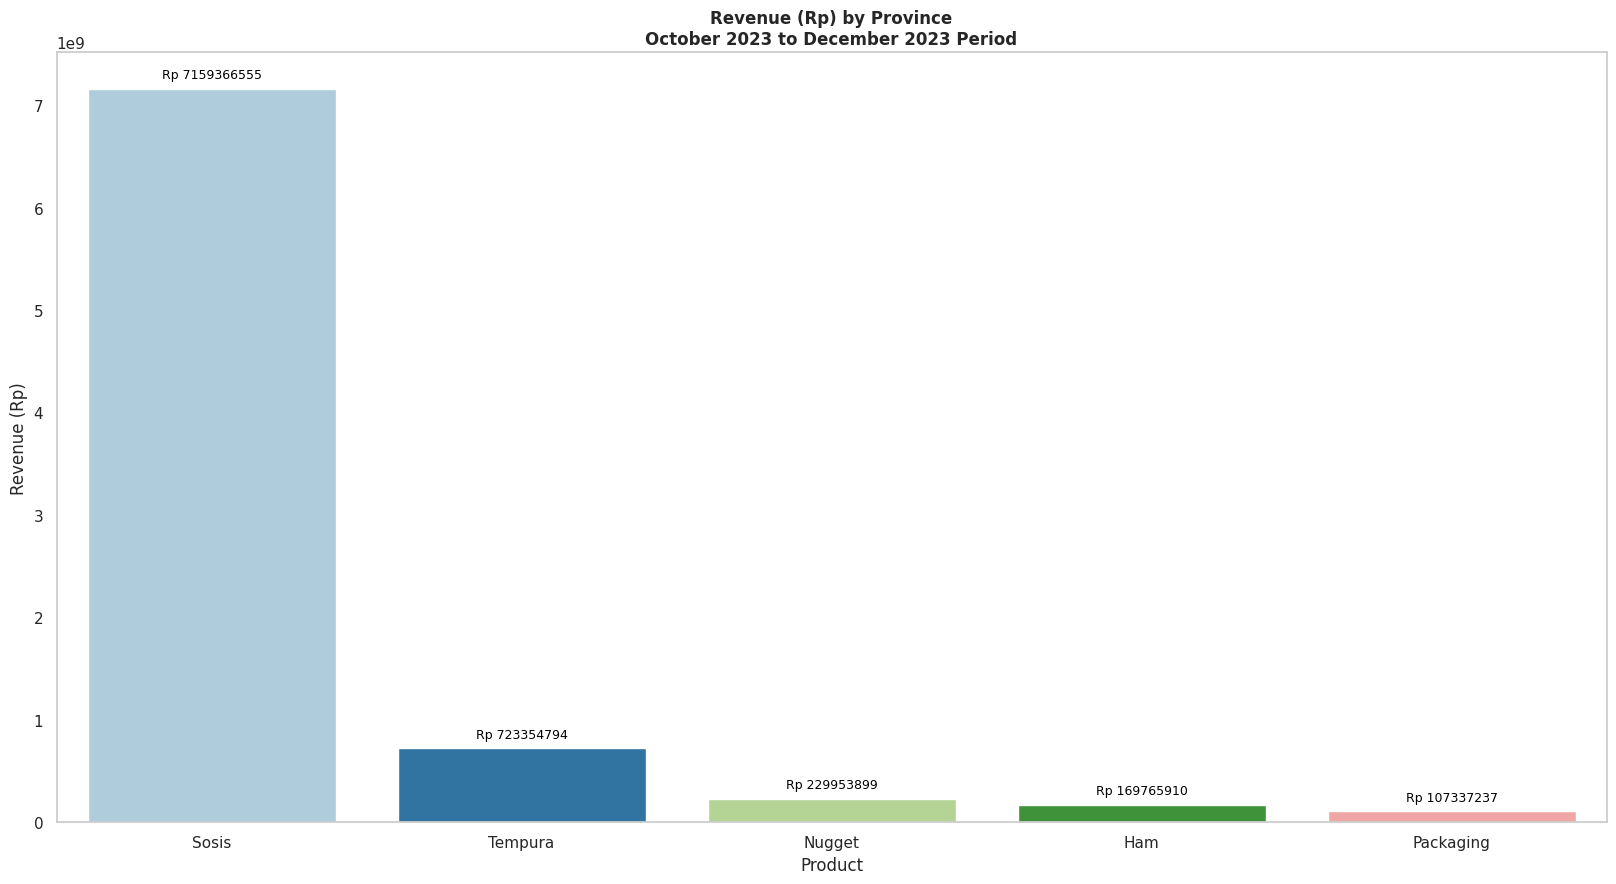

In [479]:
#create bar chart for revenue by barang
plt.figure(figsize=(20, 10))  # Adjust the figure size if needed
fig = sns.barplot(x='barang', y='revenue', data=df_barang.sort_values(by=['revenue'],ascending=False).head(), palette='Paired',ci=None)
plt.grid(False)
# Add labels to the bars
ax = fig.axes
for p in ax.patches:
    ax.annotate(f'Rp {round(int(p.get_height()),1)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')


# Adding labels and a title
plt.xlabel('Product')
plt.ylabel('Revenue (Rp)')
plt.title('Revenue (Rp) by Province\nOctober 2023 to December 2023 Period', fontweight='bold', fontsize = 12)

# Show the chart
plt.show()

In [480]:
# KPI Analysis monthly
df_kpi = df.copy()
kpi_monthly = df_kpi.groupby(['month']).agg(order_number=('tanggal','nunique'),
                                          cust_number=('kodecust','nunique'),
                                          sold_qty = ('qty','sum'),
                                          revenue = ('total','sum')).reset_index()

kpi_monthly['aov'] = kpi_monthly['revenue'] / kpi_monthly['order_number']
kpi_monthly['arpu'] = kpi_monthly['revenue'] / kpi_monthly['cust_number']
kpi_monthly['asp'] = kpi_monthly['revenue'] / kpi_monthly['sold_qty']
kpi_monthly['basket_size'] = kpi_monthly['sold_qty'] / kpi_monthly['order_number']
kpi_monthly[['aov', 'arpu', 'asp', 'basket_size']] = round(kpi_monthly[['aov', 'arpu', 'asp', 'basket_size']],2)

kpi_monthly.style.background_gradient(cmap='GnBu')

,month,order_number,cust_number,sold_qty,revenue,aov,arpu,asp,basket_size
0,2023-10,27,364,147986,2632585491,97503166.330000,7232377.720000,17789.420000,5480.960000
1,2023-11,26,353,153284,2692346779,103551799.190000,7627044.700000,17564.430000,5895.540000
2,2023-12,27,350,178985,3100832789,114845658.850000,8859522.250000,17324.540000,6629.070000


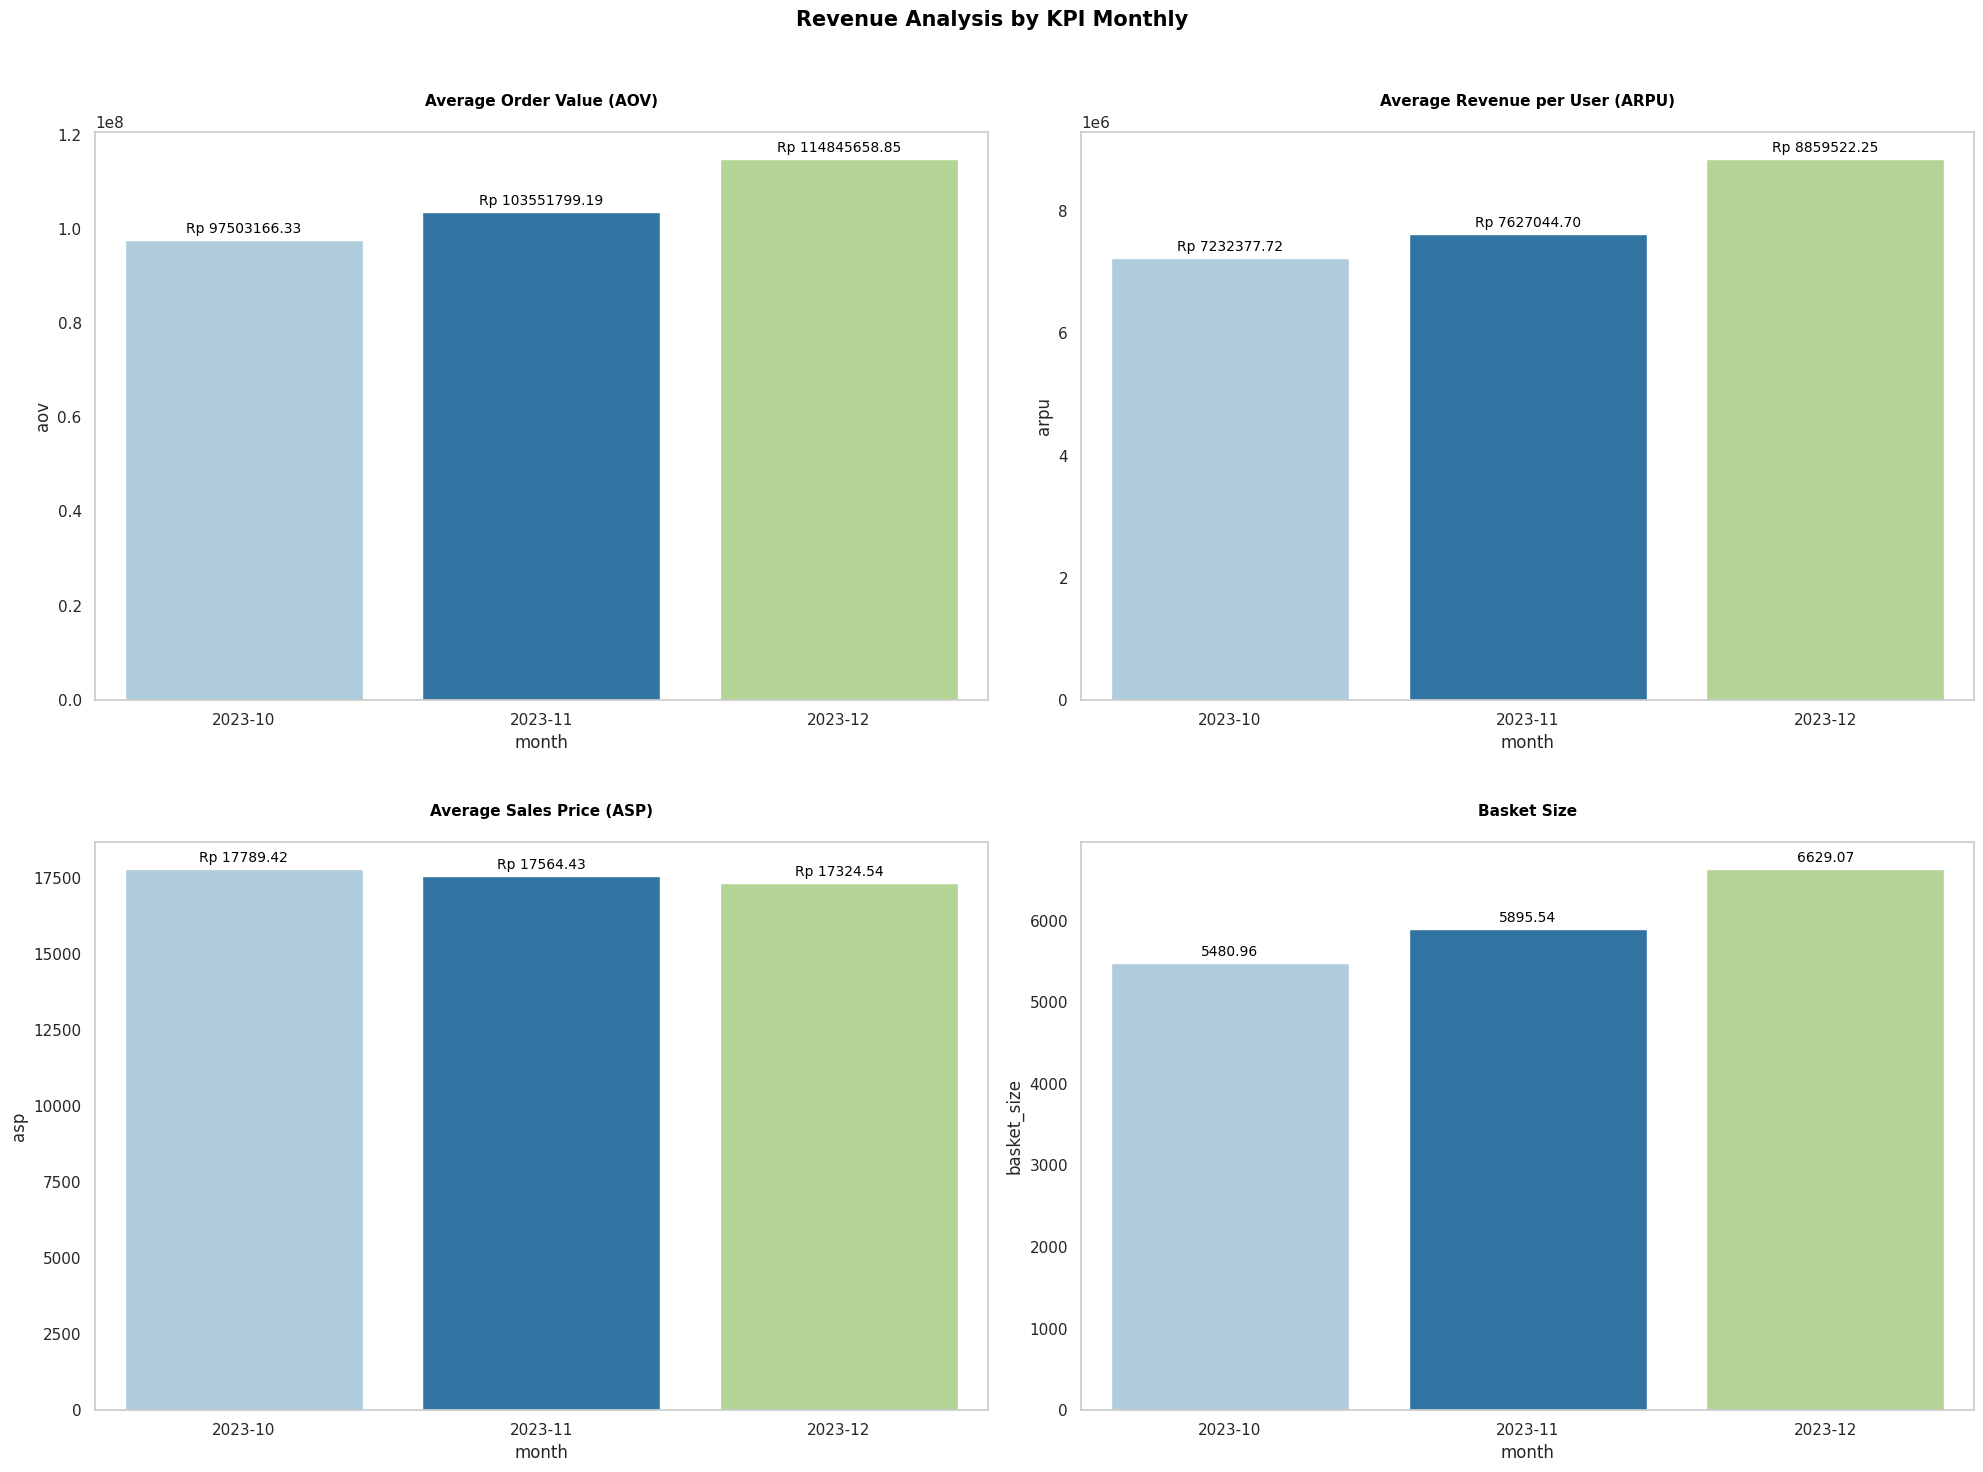

In [481]:
#Create Bar Chart to Visualized KPI Analysis Monthly

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

#Give Title
fig.suptitle('Revenue Analysis by KPI Monthly\n',color = 'black', fontweight= 'bold',fontsize = 15)


# Plot a bar chart for AOV
sns.barplot(x='month', y='aov', data=kpi_monthly, palette='Paired', ax=axes[0, 0])
axes[0][0].set_title('\n\nAverage Order Value (AOV)\n', fontweight='bold', fontsize=11, color='black')
axes[0][0].grid(False)
# Add data labels to the AOV bar chart
for bar in axes[0, 0].patches:
    height = bar.get_height()
    axes[0, 0].annotate(f'Rp {height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')


# Plot a bar chart for ARPU
sns.barplot(x='month', y='arpu', data=kpi_monthly, palette='Paired', ax=axes[0, 1])
axes[0][1].set_title('\n\nAverage Revenue per User (ARPU)\n', fontweight='bold', fontsize=11, color='black')
axes[0][1].grid(False)
# Add data labels to the AOV bar chart
for bar in axes[0, 1].patches:
    height = bar.get_height()
    axes[0, 1].annotate(f'Rp {height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')


# Plot a bar chart for ASP
sns.barplot(x='month', y='asp', data=kpi_monthly, palette='Paired', ax=axes[1, 0])
axes[1][0].set_title('\n\nAverage Sales Price (ASP)\n', fontweight='bold', fontsize=11, color='black')
axes[1][0].grid(False)
# Add data labels to the AOV bar chart
for bar in axes[1, 0].patches:
    height = bar.get_height()
    axes[1, 0].annotate(f'Rp {height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')


# Plot a bar chart for Basket Size
sns.barplot(x='month', y='basket_size', data=kpi_monthly, palette='Paired', ax=axes[1, 1])
axes[1][1].set_title('\n\nBasket Size\n', fontweight='bold', fontsize=11, color='black')
axes[1][1].grid(False)
# Add data labels to the AOV bar chart
for bar in axes[1, 1].patches:
    height = bar.get_height()
    axes[1, 1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=10, color='black')



# Adjust layout
plt.tight_layout()

plt.show()

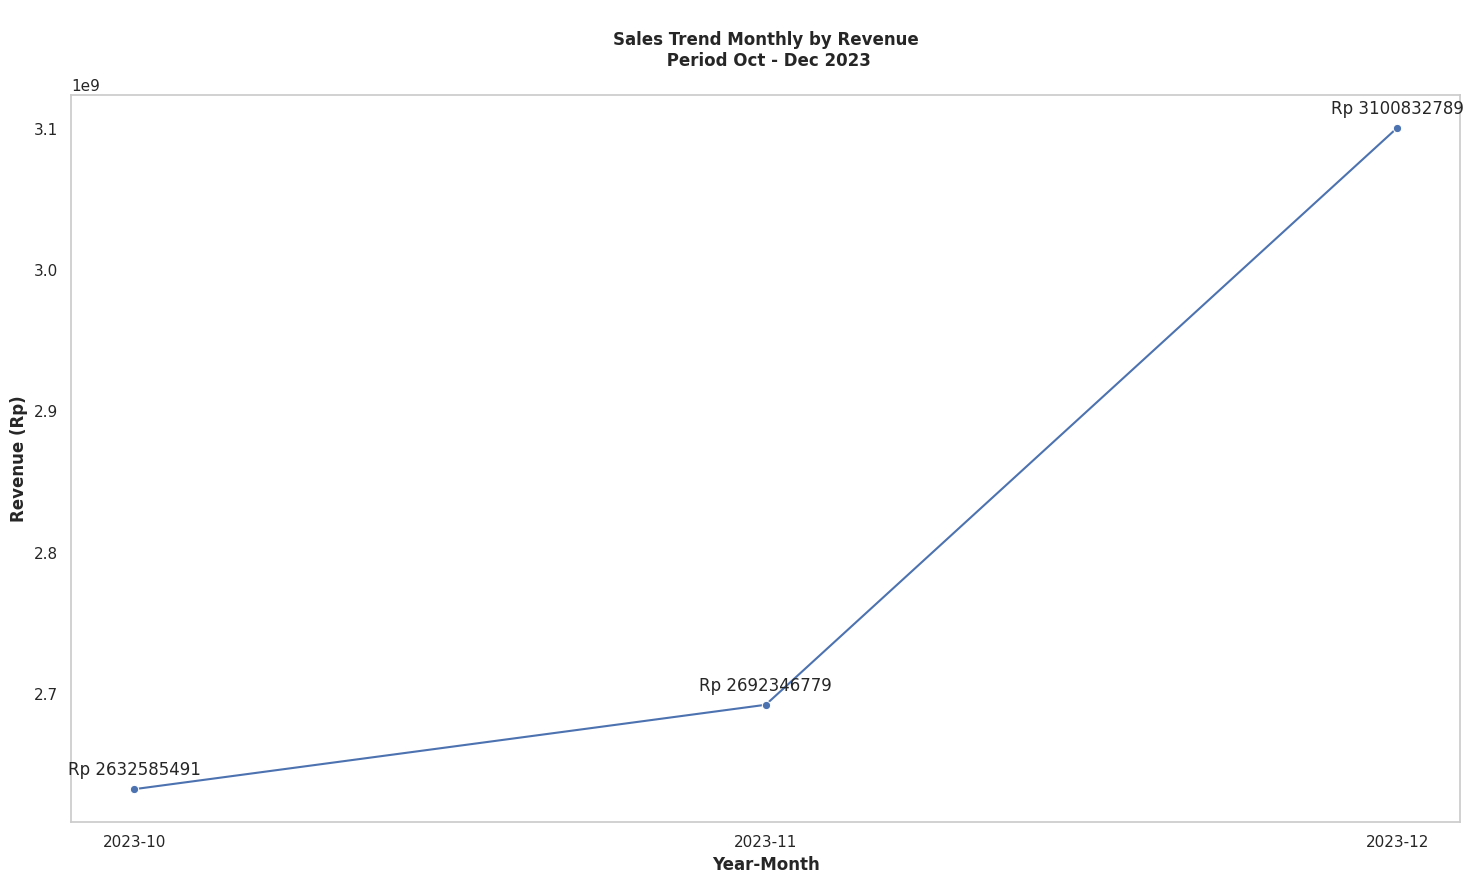

In [482]:
#Trend of Transaction by Month by Revenue
df_revenue_month = df.groupby('month').agg(revenue = ('total','sum')).reset_index()
df_revenue_month['month'] = df_revenue_month['month'].astype(str)

# Set seaborn style
sns.set(style="whitegrid")

# Plotting using seaborn
plt.figure(figsize=(15, 9))
plt.grid(False)
sns.lineplot(x='month', y='revenue', data=df_revenue_month, marker='o')

# Adding data labels
for x, y in zip(df_revenue_month['month'], df_revenue_month['revenue']):
    plt.annotate(f'Rp {y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Adding labels and title
plt.xlabel('Year-Month', fontweight = 'bold')
plt.ylabel('Revenue (Rp)', fontweight = 'bold')
plt.title('\nSales Trend Monthly by Revenue\n Period Oct - Dec 2023\n', fontweight = 'bold')

# Formatting x-axis labels for better readability
plt.xticks(rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.show()

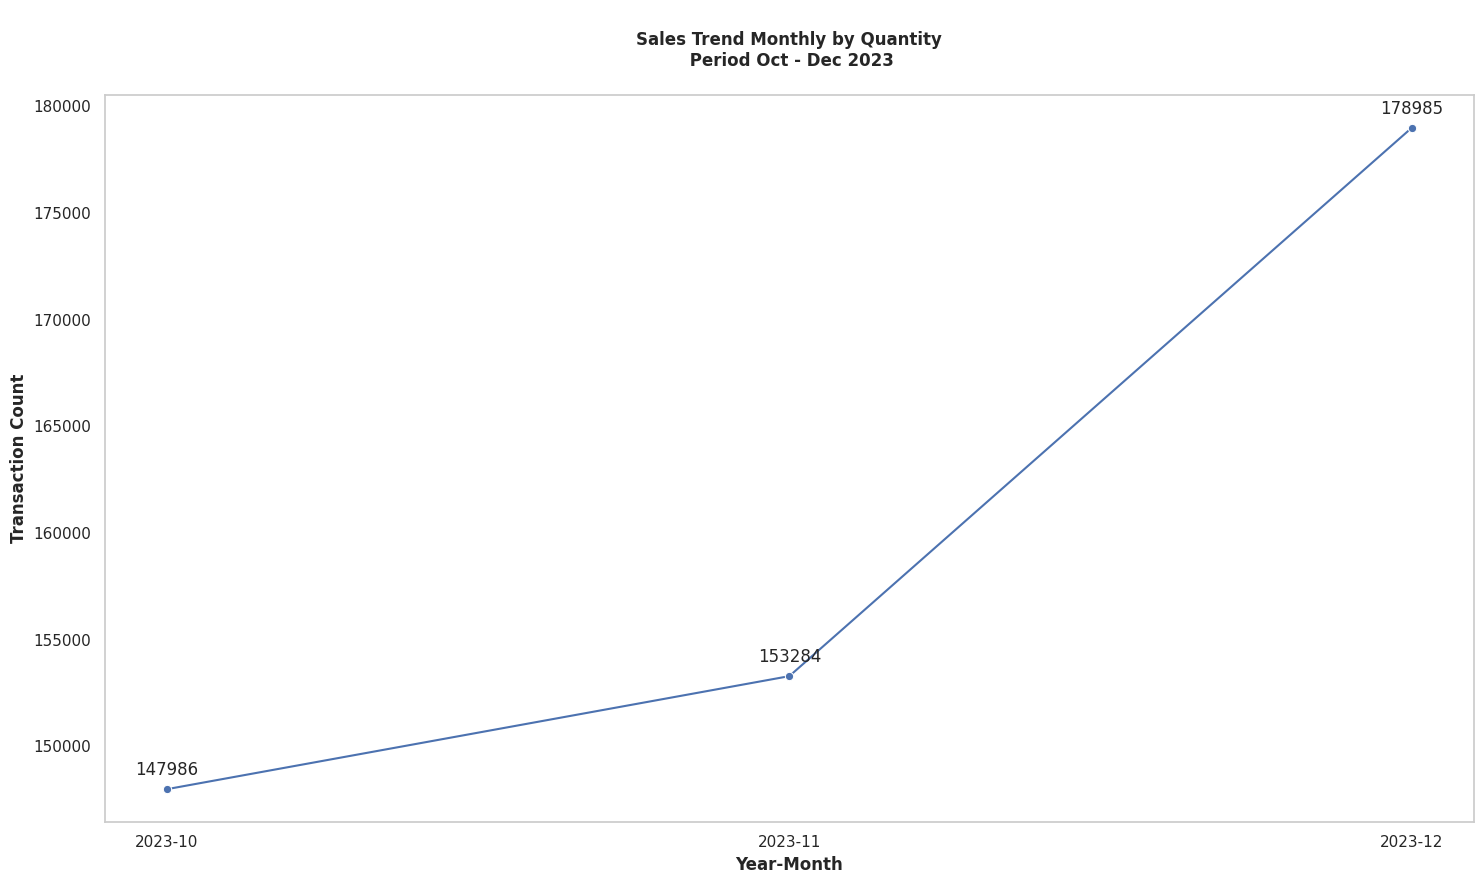

In [483]:
#Trend of Transaction by Month by Quantity
df_qty_month = df.groupby('month').agg(qty = ('qty','sum')).reset_index()
df_qty_month['month'] = df_qty_month['month'].astype(str)

# Set seaborn style
sns.set(style="whitegrid")

# Plotting using seaborn
plt.figure(figsize=(15, 9))
plt.grid(False)
fig = sns.lineplot(x='month', y='qty', data=df_qty_month, marker='o')


# Adding data labels
for x, y in zip(df_qty_month['month'], df_qty_month['qty']):
    plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Adding labels and title
plt.xlabel('Year-Month', fontweight = 'bold')
plt.ylabel('Transaction Count', fontweight = 'bold')
plt.title('\nSales Trend Monthly by Quantity\n Period Oct - Dec 2023\n', fontweight = 'bold')

# Formatting x-axis labels for better readability
plt.xticks(rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.show()

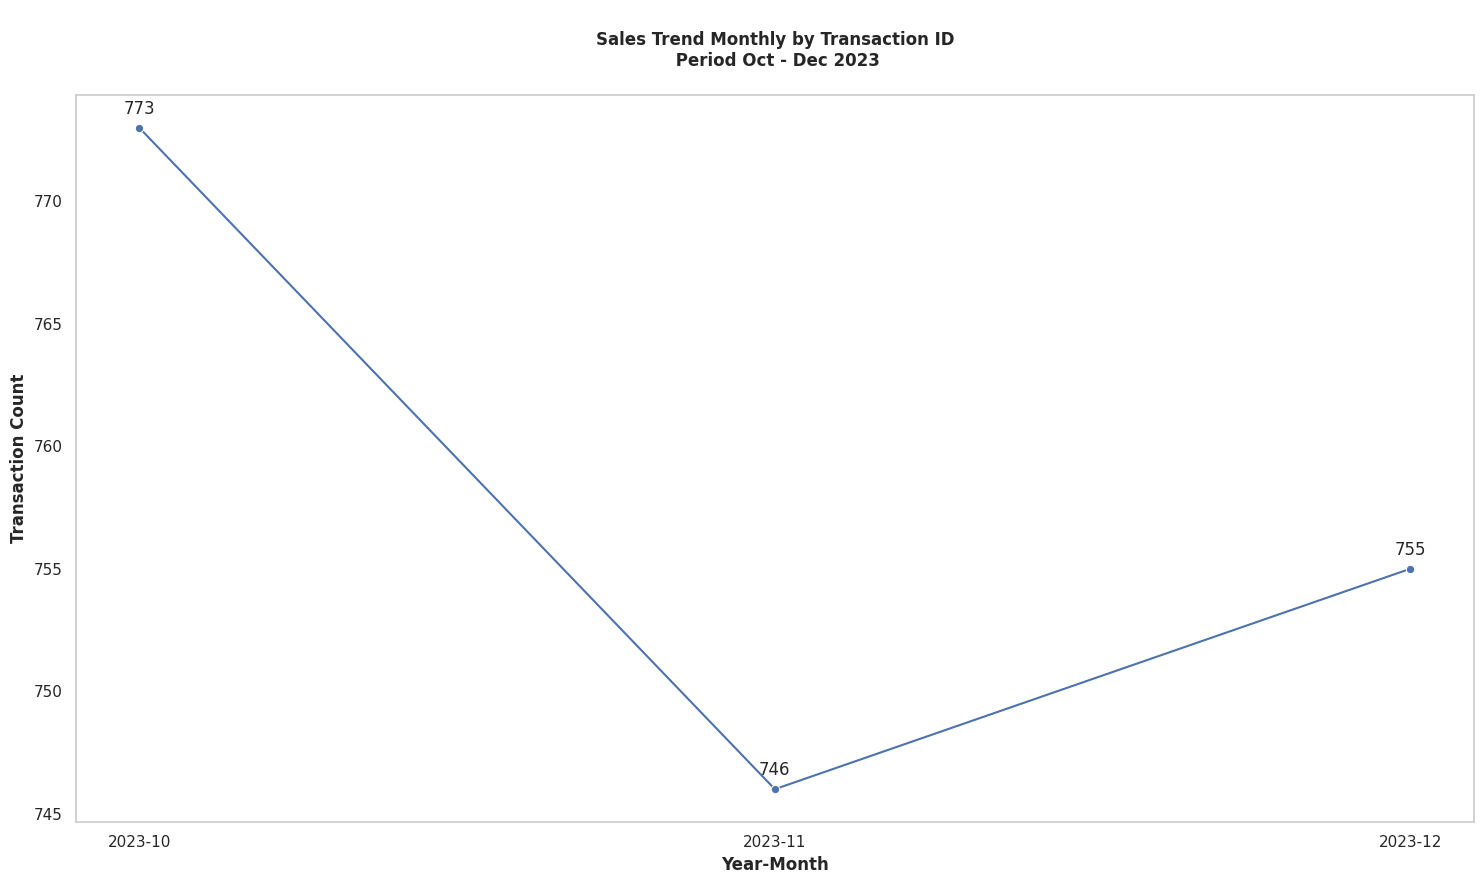

In [484]:
#Trend of Transaction by Month by Transaction ID
df_trx_month = df.groupby('month').agg(transaction_count = ('transaction_id','nunique')).reset_index()
df_trx_month['month'] = df_trx_month['month'].astype(str)

# Set seaborn style
sns.set(style="whitegrid")

# Plotting using seaborn
plt.figure(figsize=(15, 9))
plt.grid(False)
fig = sns.lineplot(x='month', y='transaction_count', data=df_trx_month, marker='o')

# Adding data labels
for x, y in zip(df_trx_month['month'], df_trx_month['transaction_count']):
    plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Adding labels and title
plt.xlabel('Year-Month', fontweight = 'bold')
plt.ylabel('Transaction Count', fontweight = 'bold')
plt.title('\nSales Trend Monthly by Transaction ID\n Period Oct - Dec 2023\n', fontweight = 'bold')

# Formatting x-axis labels for better readability
plt.xticks(rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.show()

In [485]:
#find retention rate each month
df_new_cust = df_cust_occurence[df_cust_occurence['cust_occurence']=='New Customer'].groupby(by=['month','tanggal']).agg(new_cust=('kodecust','nunique')).reset_index()
df_existing_cust = df_cust_occurence[df_cust_occurence['cust_occurence']=='Existing Customer'].groupby(by=['month','tanggal']).agg(existing_cust=('kodecust','nunique')).reset_index()

df_retention = df_new_cust.merge(df_existing_cust, how='left', on=['month','tanggal']).reset_index(drop=True)
df_retention = df_retention.groupby('month').agg(new_cust=('new_cust','sum'),
                                                 existing_cust_m0 = ('existing_cust','first'),
                                                 existing_cust_m1 = ('existing_cust','last')).sort_values('month').reset_index()
df_retention['retention rate (%)'] = round((df_retention['existing_cust_m1'] - df_retention['new_cust'])/df_retention['existing_cust_m0'],2)
df_retention

,month,new_cust,existing_cust_m0,existing_cust_m1,retention rate (%)
0,2023-10,364,18,36,-18.22
1,2023-11,86,28,35,-1.82
2,2023-12,52,28,30,-0.79


In [486]:
#find top spender in each customer
df_top_spender = df.groupby(by=['kodecust','kota','propinsi']).agg(transaction_count=('transaction_id','nunique'),
                                                                   quantity = ('qty','sum'),
                                                                   revenue=('total','sum')).sort_values('revenue',ascending=False).reset_index()
df_top_spender.head(10)

,kodecust,kota,propinsi,transaction_count,quantity,revenue
0,D00393,Jakarta,DKI Jakarta,12,42350,729663590
1,F00008,Yogyakarta,DI Yogyakarta,14,29116,523883229
2,01K00015,Denpasar,Bali,11,28020,486263595
3,01R00073,Depok,Jawa Barat,27,17699,316420900
4,K00163,Sidoarjo,Jawa Timur,14,14320,267953560
5,R00221,Klaten,Jawa Tengah,27,13879,234875087
6,W00032,Makassar,Sulawesi Selatan,19,12762,225279796
7,01H00060,Jakarta,DKI Jakarta,17,10865,205963025
8,C00114,Surabaya,Jawa Timur,57,11688,205110028
9,P00217,Kudus,Jawa Tengah,12,12009,203288639


In [487]:
#using apriori algorithm
basket = df.groupby(['transaction_id', 'barang'])['qty'].sum().unstack().fillna(0)

# Convert quantities to binary values (1 if item is in the transaction, 0 otherwise)
basket[basket > 0] = 1

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.025, use_colnames=True)

# Extract association rules
association_rules_category_df = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)

# Interpret the association rules and identify products to bundle

# For example, to identify items that are frequently purchased together:
frequent_itemsets['itemsets'].apply(lambda x: list(x))

0                   [Dry Ice]
1                       [Ham]
2                    [Nugget]
3                 [Packaging]
4              [Perlengkapan]
5                     [Sosis]
6                   [Tempura]
7     [Perlengkapan, Dry Ice]
8            [Packaging, Ham]
9         [Perlengkapan, Ham]
10               [Sosis, Ham]
11             [Ham, Tempura]
12            [Sosis, Nugget]
13          [Nugget, Tempura]
14         [Packaging, Sosis]
15      [Perlengkapan, Sosis]
16           [Sosis, Tempura]
17    [Packaging, Sosis, Ham]
Name: itemsets, dtype: object

In [488]:
association_rules_category_df.sort_values('lift', ascending=False).reset_index(drop=True).style.background_gradient(cmap='BuGn')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,frozenset({'Perlengkapan'}),frozenset({'Dry Ice'}),0.071240,0.031223,0.029464,0.413580,13.246218,0.027239,1.652021,0.995421
1,frozenset({'Dry Ice'}),frozenset({'Perlengkapan'}),0.031223,0.071240,0.029464,0.943662,13.246218,0.027239,16.485488,0.954302
2,frozenset({'Perlengkapan'}),frozenset({'Ham'}),0.071240,0.262973,0.040457,0.567901,2.159544,0.021723,1.705692,0.578125
3,frozenset({'Ham'}),frozenset({'Perlengkapan'}),0.262973,0.071240,0.040457,0.153846,2.159544,0.021723,1.097625,0.728520
4,frozenset({'Packaging'}),"frozenset({'Sosis', 'Ham'})",0.105981,0.170185,0.031662,0.298755,1.755476,0.013626,1.183346,0.481370
5,"frozenset({'Sosis', 'Ham'})",frozenset({'Packaging'}),0.170185,0.105981,0.031662,0.186047,1.755476,0.013626,1.098367,0.518614
6,frozenset({'Packaging'}),frozenset({'Ham'}),0.105981,0.262973,0.045295,0.427386,1.625210,0.017425,1.287127,0.430298
7,frozenset({'Ham'}),frozenset({'Packaging'}),0.262973,0.105981,0.045295,0.172241,1.625210,0.017425,1.080048,0.521955
8,frozenset({'Ham'}),"frozenset({'Packaging', 'Sosis'})",0.262973,0.084872,0.031662,0.120401,1.418615,0.009343,1.040392,0.400375
9,"frozenset({'Packaging', 'Sosis'})",frozenset({'Ham'}),0.084872,0.262973,0.031662,0.373057,1.418615,0.009343,1.175589,0.322454


In [489]:
association_rules_category_df.sort_values('support', ascending=False).reset_index(drop=True).style.background_gradient(cmap='BuGn')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,frozenset({'Ham'}),frozenset({'Sosis'}),0.262973,0.803430,0.170185,0.647157,0.805493,-0.041096,0.557103,-0.246781
1,frozenset({'Sosis'}),frozenset({'Ham'}),0.803430,0.262973,0.170185,0.211823,0.805493,-0.041096,0.935103,-0.551257
2,frozenset({'Tempura'}),frozenset({'Sosis'}),0.213281,0.803430,0.127089,0.595876,0.741665,-0.044267,0.486410,-0.306877
3,frozenset({'Sosis'}),frozenset({'Tempura'}),0.803430,0.213281,0.127089,0.158183,0.741665,-0.044267,0.934549,-0.639246
4,frozenset({'Sosis'}),frozenset({'Packaging'}),0.803430,0.105981,0.084872,0.105638,0.996764,-0.000276,0.999616,-0.016249
5,frozenset({'Packaging'}),frozenset({'Sosis'}),0.105981,0.803430,0.084872,0.800830,0.996764,-0.000276,0.986945,-0.003619
6,frozenset({'Nugget'}),frozenset({'Sosis'}),0.101583,0.803430,0.077397,0.761905,0.948315,-0.004218,0.825594,-0.057195
7,frozenset({'Sosis'}),frozenset({'Nugget'}),0.803430,0.101583,0.077397,0.096333,0.948315,-0.004218,0.994190,-0.217077
8,frozenset({'Perlengkapan'}),frozenset({'Sosis'}),0.071240,0.803430,0.048373,0.679012,0.845142,-0.008864,0.612391,-0.164779
9,frozenset({'Sosis'}),frozenset({'Perlengkapan'}),0.803430,0.071240,0.048373,0.060208,0.845142,-0.008864,0.988261,-0.482443


In [490]:
association_rules_category_df.sort_values('confidence', ascending=False).reset_index(drop=True).style.background_gradient(cmap='BuGn')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,frozenset({'Dry Ice'}),frozenset({'Perlengkapan'}),0.031223,0.071240,0.029464,0.943662,13.246218,0.027239,16.485488,0.954302
1,frozenset({'Packaging'}),frozenset({'Sosis'}),0.105981,0.803430,0.084872,0.800830,0.996764,-0.000276,0.986945,-0.003619
2,frozenset({'Nugget'}),frozenset({'Sosis'}),0.101583,0.803430,0.077397,0.761905,0.948315,-0.004218,0.825594,-0.057195
3,"frozenset({'Packaging', 'Ham'})",frozenset({'Sosis'}),0.045295,0.803430,0.031662,0.699029,0.870056,-0.004729,0.653119,-0.135275
4,frozenset({'Perlengkapan'}),frozenset({'Sosis'}),0.071240,0.803430,0.048373,0.679012,0.845142,-0.008864,0.612391,-0.164779
5,frozenset({'Ham'}),frozenset({'Sosis'}),0.262973,0.803430,0.170185,0.647157,0.805493,-0.041096,0.557103,-0.246781
6,frozenset({'Tempura'}),frozenset({'Sosis'}),0.213281,0.803430,0.127089,0.595876,0.741665,-0.044267,0.486410,-0.306877
7,frozenset({'Perlengkapan'}),frozenset({'Ham'}),0.071240,0.262973,0.040457,0.567901,2.159544,0.021723,1.705692,0.578125
8,frozenset({'Packaging'}),frozenset({'Ham'}),0.105981,0.262973,0.045295,0.427386,1.625210,0.017425,1.287127,0.430298
9,frozenset({'Perlengkapan'}),frozenset({'Dry Ice'}),0.071240,0.031223,0.029464,0.413580,13.246218,0.027239,1.652021,0.995421


# **4. RFM Analysis**

In [491]:
#create rfm to calculate rfm
reference_date = df.tanggal.max() + dt.timedelta(days = 1)
rfm = df.groupby(['kodecust']).agg(recency = ('tanggal',lambda x: (reference_date - x.max()).days),
                                       frequency = ('transaction_id','nunique'),
                                       monetary = ('total','sum')).reset_index()

rfm.head(10)

,kodecust,recency,frequency,monetary
0,01A00120,2,11,197387732
1,01A00143,14,6,28053361
2,01B00001,20,6,69337400
3,01C00017,46,3,1025496
4,01H00060,4,17,205963025
5,01I00016,7,31,109881139
6,01I00061,42,2,1765400
7,01K00015,11,11,486263595
8,01N00026,18,3,11422893
9,01R00073,4,27,316420900


In [492]:
#create percentiles_df
percentiles_df = round(rfm.rank(pct=True,method='dense'),3)
percentiles_df.head()

,kodecust,recency,frequency,monetary
0,0.002,0.027,0.379,0.980
1,0.004,0.178,0.207,0.888
2,0.006,0.247,0.207,0.950
3,0.008,0.548,0.103,0.357
4,0.010,0.055,0.586,0.986


In [493]:
# determine RFM Score
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['rfm_score'] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str))

def rfm_identifier(score):
  if re.match(r'5\d\d', score) != None:
    return 'Premium'
  elif re.match(r'4\d\d', score) != None:
    return 'Gold'
  elif re.match(r'3\d\d', score) != None:
    return 'Silver'
  else:
    return 'Standard'

rfm['segmentation'] = rfm['rfm_score'].apply(rfm_identifier)
rfm['rfm_score'] = rfm['rfm_score'].astype(int)
rfm.sort_values(by=['rfm_score'], ascending=False).reset_index(drop=True).style.background_gradient(cmap='BuGn')

,kodecust,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,segmentation
0,01A00120,2,11,197387732,5,5,5,555,Premium
1,K00158,2,42,44641650,5,5,5,555,Premium
2,R00221,3,27,234875087,5,5,5,555,Premium
3,I00376,4,6,19998348,5,5,5,555,Premium
4,W00032,5,19,225279796,5,5,5,555,Premium
5,D00035,3,10,41072205,5,5,5,555,Premium
6,D00013,5,15,44436497,5,5,5,555,Premium
7,K00163,2,14,267953560,5,5,5,555,Premium
8,C00114,3,57,205110028,5,5,5,555,Premium
9,R00446,4,12,102566768,5,5,5,555,Premium


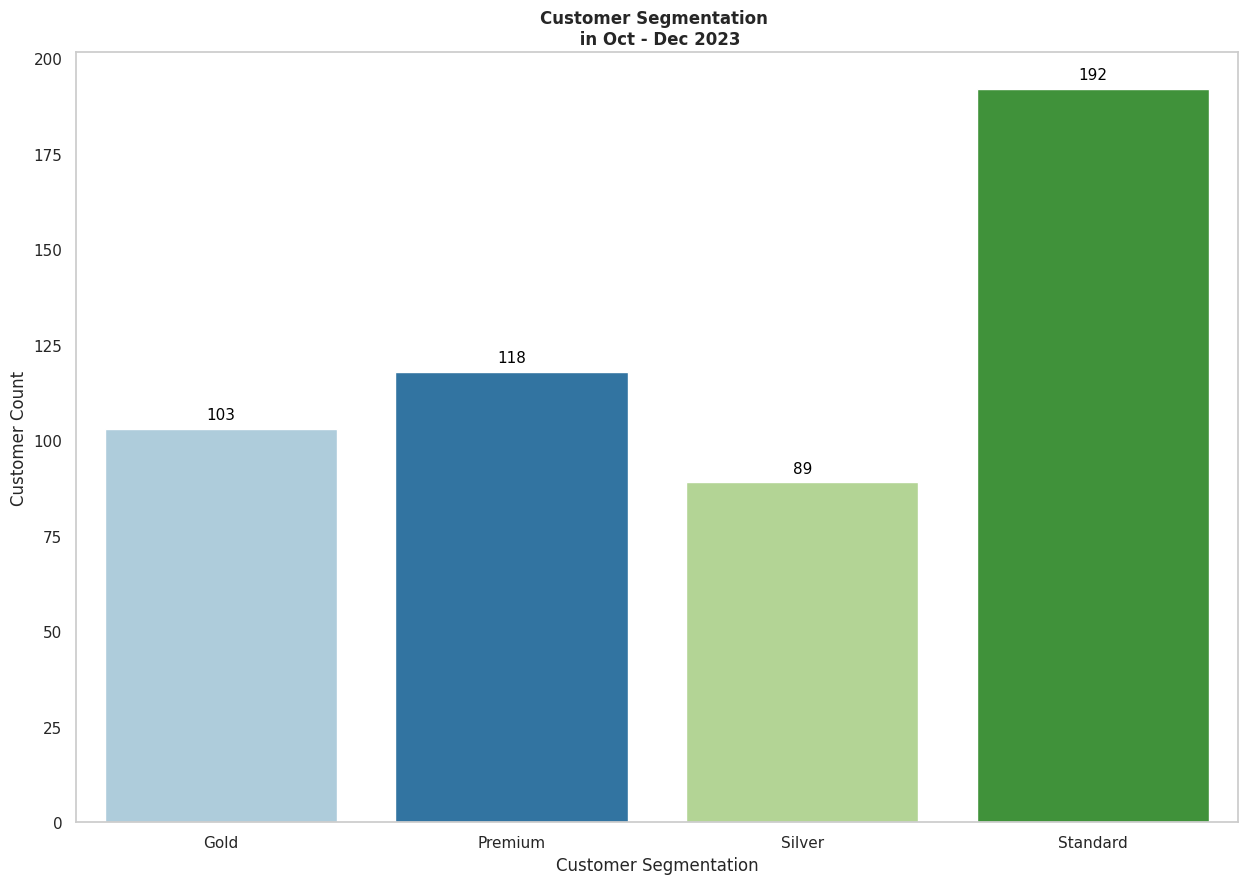

In [494]:
# Create a Bar Chart to show Customer Segmentation
plt.figure(figsize=(15, 10))  # Adjust the figure size if needed
plt.grid(False)
fig = sns.barplot(x='segmentation',
                  y='customer_cnt',
                  data = rfm.groupby(['segmentation']).agg(customer_cnt=('kodecust','nunique')).reset_index(),
                  palette='Paired')

# Add labels to the bars
ax = fig.axes
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 10), textcoords='offset points')

# Adding labels and a title
plt.xlabel('Customer Segmentation')
plt.ylabel('Customer Count')
plt.title('Customer Segmentation \n in Oct - Dec 2023', fontweight='bold', fontsize = 12)

# Show the chart
plt.show()

In [495]:
# Define a dictionary containing employee data
data = {'Percent_Customers':['1%', '5%', '10%', '20%','100%'],
        'Percentage':[0.01,0.05,0.1,0.2,1]}

# Convert the dictionary into DataFrame
df_topcust = pd.DataFrame(data)
# select two columns
df_topcust.columns = (['Percent_Customers', 'Percentage'])
df_topcust['Cumulative_Customers'] = round(df_topcust['Percentage']*(df_top_spender['kodecust'].nunique())).astype(int)

def foo(row):   # row is a Series
    if row.Percent_Customers == '1%':
        return (df_top_spender.loc[:4,['revenue']]).sum()
    elif row.Percent_Customers == '5%':
        return (df_top_spender.loc[5:24,['revenue']]).sum()
    elif row.Percent_Customers == '10%':
        return (df_top_spender.loc[25:49,['revenue']]).sum()
    elif row.Percent_Customers == '20%':
        return (df_top_spender.loc[50:99,['revenue']]).sum()
    else:
        return (df_top_spender.loc[100:501,['revenue']]).sum()

df_topcust['Sales Revenue'] = df_topcust.apply(foo, axis=1)
df_topcust['Cumulative Sales Revenue'] = df_topcust['Sales Revenue'].cumsum()

def foo(row):   # row is a Series
    if row.Percent_Customers == '1%':
        return (df_top_spender.loc[:4,['transaction_count']]).sum()
    elif row.Percent_Customers == '5%':
        return (df_top_spender.loc[5:24,['transaction_count']]).sum()
    elif row.Percent_Customers == '10%':
        return (df_top_spender.loc[25:49,['transaction_count']]).sum()
    elif row.Percent_Customers == '20%':
        return (df_top_spender.loc[50:99,['transaction_count']]).sum()
    else:
        return (df_top_spender.loc[100:501,['transaction_count']]).sum()

df_topcust['Sales Transaction'] = df_topcust.apply(foo, axis=1)

def foo(row):   # row is a Series
    if row.Percent_Customers == '1%':
        return (df_top_spender.loc[:4,['quantity']]).sum()
    elif row.Percent_Customers == '5%':
        return (df_top_spender.loc[5:24,['quantity']]).sum()
    elif row.Percent_Customers == '10%':
        return (df_top_spender.loc[25:49,['quantity']]).sum()
    elif row.Percent_Customers == '20%':
        return (df_top_spender.loc[50:99,['quantity']]).sum()
    else:
        return (df_top_spender.loc[100:501,['quantity']]).sum()

df_topcust['Sales Quantity'] = df_topcust.apply(foo, axis=1)
df_topcust['AOV'] = round(df_topcust['Sales Revenue'] / df_topcust['Sales Transaction'],2)
df_topcust['ASP'] = round(df_topcust['Sales Revenue'] / df_topcust['Sales Quantity'],2).astype(float)
df_topcust['Basket Size'] = round(df_topcust['Sales Quantity'] / df_topcust['Sales Transaction'],2)



df_topcust

,Percent_Customers,Percentage,Cumulative_Customers,Sales Revenue,Cumulative Sales Revenue,Sales Transaction,Sales Quantity,AOV,ASP,Basket Size
0,1%,0.01,5,2324184874,2324184874,78,131505,29797241.97,17673.74,1685.96
1,5%,0.05,25,2969729760,5293914634,292,169406,10170307.40,17530.25,580.16
2,10%,0.10,50,1228279628,6522194262,335,69768,3666506.35,17605.20,208.26
3,20%,0.20,100,934295222,7456489484,337,53029,2772389.38,17618.57,157.36
4,100%,1.00,502,969275575,8425765059,1232,56547,786749.66,17141.06,45.90


In [496]:
#create new data df
df = df_cust_occurence.copy()
df.drop(['namacust','month'],axis=1,inplace=True)
df.head()

,tanggal,kodecust,kota,propinsi,channel,salesman,barang,qty,total,transaction_id,cust_occurence
0,2023-10-02,01C00017,Bandung,Jawa Barat,GT,DL06,Sosis,6,86802,2023100201C00017GTDL06,New Customer
1,2023-10-02,01C00017,Bandung,Jawa Barat,GT,DL06,Sosis,7,138299,2023100201C00017GTDL06,Existing Customer
2,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,50,1021900,2023100201H00060GTWD05,New Customer
3,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,50,733300,2023100201H00060GTWD05,Existing Customer
4,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,140,3167360,2023100201H00060GTWD05,Existing Customer


In [497]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6838 entries, 0 to 6837
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tanggal         6838 non-null   datetime64[ns]
 1   kodecust        6838 non-null   object        
 2   kota            6838 non-null   object        
 3   propinsi        6838 non-null   object        
 4   channel         6838 non-null   object        
 5   salesman        6838 non-null   object        
 6   barang          6838 non-null   object        
 7   qty             6838 non-null   int64         
 8   total           6838 non-null   int64         
 9   transaction_id  6838 non-null   object        
 10  cust_occurence  6838 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 587.8+ KB


In [498]:
df['qty'].sum()

480255

In [499]:
df['total'].sum()

8425765059

In [500]:
df['kodecust'].nunique()

502

In [501]:
df['transaction_id'].nunique()

2274

In [502]:
import pandas as pd
import pandas_gbq

def check_drop_export_rows_dataframe(df, project_id, dataset_id, table_id):
    affected_rows = []
    affected_columns = []

    for index, row in df.iterrows():
        try:
            row.astype(bytes)
        except (TypeError, ValueError):
            affected_rows.append(index)

    for column in df.columns:
        try:
            df[column] = df[column].astype(str)
        except (TypeError, ValueError):
            affected_columns.append(column)

    # Drop affected rows
    df = df.drop(index=affected_rows)

    # Export DataFrame to Google BigQuery
    pandas_gbq.to_gbq(df, f"{project_id}.{dataset_id}.{table_id}", project_id=project_id, if_exists='replace')

    return df

# Example usage
# Create a sample DataFrame
df = df.copy()

# Set your Google BigQuery project, dataset, and table
project_id = 'personalprojectreza'
dataset_id = 'tammahrobah_sales_performance'
table_id = 'sales_performance_data'

# Check for affected rows, drop them, and export to BigQuery
df = check_drop_export_rows_dataframe(df, project_id, dataset_id, table_id)

# Print the resulting DataFrame
df.head()

100%|██████████| 1/1 [00:00<00:00, 7256.58it/s]


,tanggal,kodecust,kota,propinsi,channel,salesman,barang,qty,total,transaction_id,cust_occurence
0,2023-10-02,01C00017,Bandung,Jawa Barat,GT,DL06,Sosis,6,86802,2023100201C00017GTDL06,New Customer
1,2023-10-02,01C00017,Bandung,Jawa Barat,GT,DL06,Sosis,7,138299,2023100201C00017GTDL06,Existing Customer
2,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,50,1021900,2023100201H00060GTWD05,New Customer
3,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,50,733300,2023100201H00060GTWD05,Existing Customer
4,2023-10-02,01H00060,Jakarta,DKI Jakarta,GT,WD05,Sosis,140,3167360,2023100201H00060GTWD05,Existing Customer
